# Importações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Leitura dataset e pré-processamento

In [2]:
global dataset
global dataset_original

def load_dataset(name='dataset-unificado.csv'):
    global dataset
    global dataset_original
    
    dataset = pd.read_csv(name, sep=';')
    dataset_original = dataset
    
def under_sampling(sampling_strategy={1:800, 2:320}):
    global dataset
    global dataset_original
    
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:299, 2:900, 3:826, 4:458, 5:233})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:454, 2:970, 3:717, 4:458, 5:204})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:800, 2:520})
    rus = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:700, 2:270, 3:692})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:655, 2:229, 3:648})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:454})
    X_res, y_res = rus.fit_resample(
            pd.DataFrame(dataset.index.array)[0].values.reshape(-1,1), 
            dataset['Cyclomatic'].values
    )
    
    dataset['idx'] = dataset.index
    idx_selected = X_res.reshape(1,-1)[0]
    dataset['selected'] = dataset['idx'].apply(lambda idx: idx in idx_selected)
    dataset = dataset[dataset['selected']]
    dataset = dataset.drop('idx', axis=1)
    dataset = dataset.drop('selected', axis=1)
    
def remove_last_column():
    global dataset
    
    dataset = dataset.iloc[:,:-1]
    
def remove_nan():
    global dataset
    
    dataset = dataset.dropna()
    
def fix_coverage_metrics():
    global dataset
    
    dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')) if type(ppc) == str else ppc)
    dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')) if type(ec) == str else ppc)
    dataset_original['PrimePathCoverage'] = dataset_original['PrimePathCoverage'].apply(lambda ppc: float(ppc.replace(',', '.')) if type(ppc) == str else ppc)
    dataset_original['EdgeCoverage'] = dataset_original['EdgeCoverage'].apply(lambda ec: float(ec.replace(',', '.')) if type(ec) == str else ppc)
    
def remove_coverage_metrics_with_zero():
    global dataset
    
    dataset = dataset[(dataset['EdgeCoverage'] != 0) | (dataset['PrimePathCoverage'] != 0)]
    #dataset = dataset[dataset['PrimePathCoverage'] > 0]
    
def select_metrics(metrics):
    global dataset
    
    dataset = dataset[metrics]

In [3]:
original_metrics = [
    # Método testado
    'Name','CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
]

selected_metrics = [
    # Método testado
    'Name','CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

In [4]:
load_dataset()
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
under_sampling()
select_metrics(selected_metrics)

# Características do dataset original

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

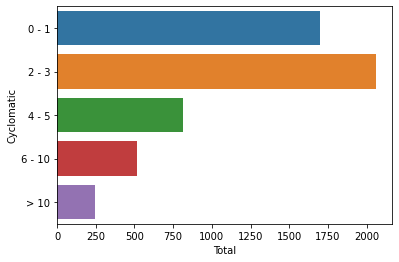

In [82]:
def get_level_of_cyclomatic(level):
    if level <= 1:
        return '0 - 1'
    elif level <= 3:
        return '2 - 3'
    elif level <= 5:
        return '4 - 5'
    elif level <= 10:
        return '6 - 10'

    #elif level <= 20:
    #    return '16 - 20'
    
    return '> 10'


d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 1', '2 - 3', '4 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

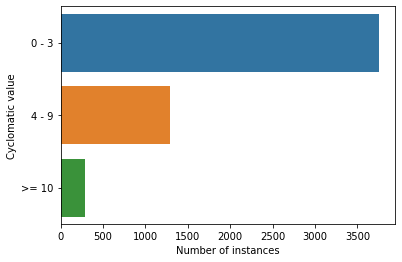

In [111]:
def get_level_of_cyclomatic(level):
    if level <= 3:
        return '0 - 3'
    elif level <= 9:
        return '4 - 9'

    return '>= 10'


d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 3', '4 - 9', '>= 10'])
ax.set(xlabel='Number of instances', ylabel='Cyclomatic value')
plt.savefig('cyclomatic-chart-noprocessing.png', dpi=300)

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

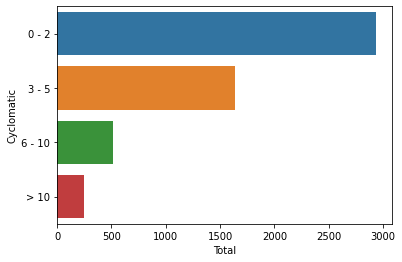

In [80]:
def get_level_of_cyclomatic(level):
    if level <= 2:
        return '0 - 2'
    elif level <= 5:
        return '3 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 2', '3 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

Dataset size:  5342
Média complexidade dataset:  3.3569824035941593


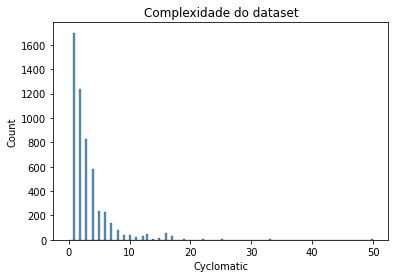

In [87]:
print('Dataset size: ', dataset_original.shape[0])
print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
plt.title("Complexidade do dataset")
sns.histplot(dataset_original['Cyclomatic'])
plt.show()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

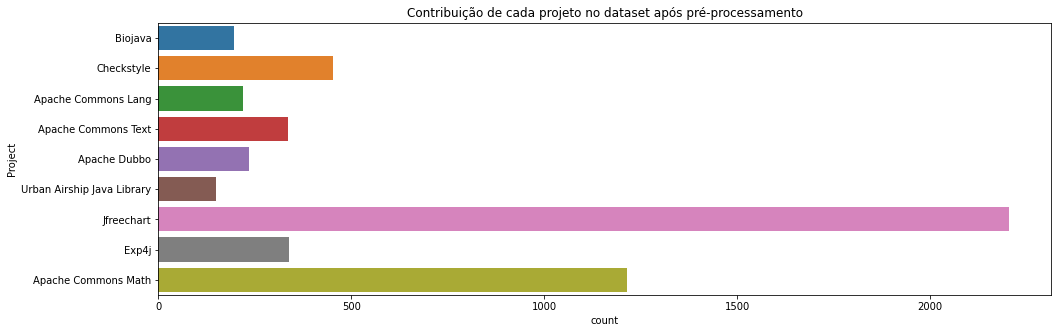

In [84]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset_original
d2['Project'] = dataset_original['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:title={'center':'Correlação das métricas'}>

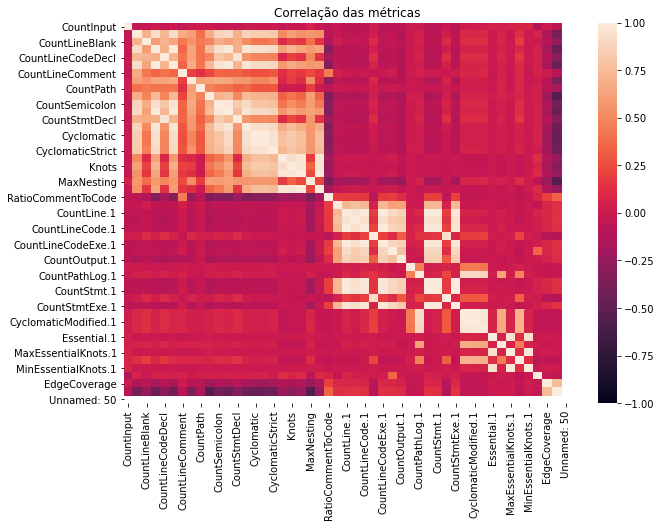

In [98]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas")
sns.heatmap(dataset_original.corr(), vmin=-1, vmax=1)

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

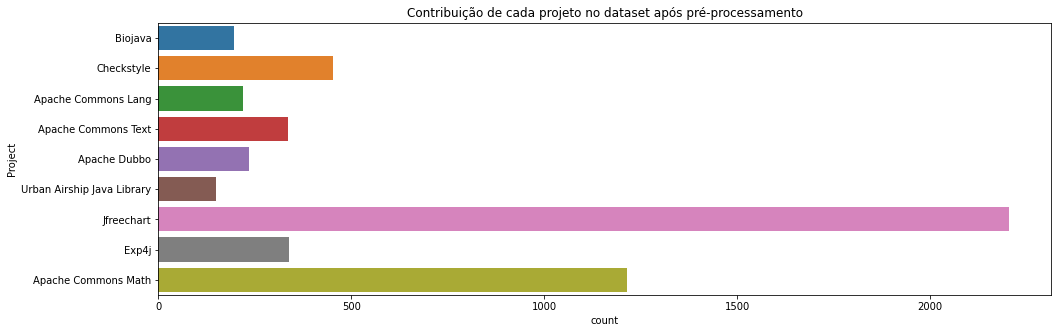

In [94]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset_original
d2['Project'] = dataset_original['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

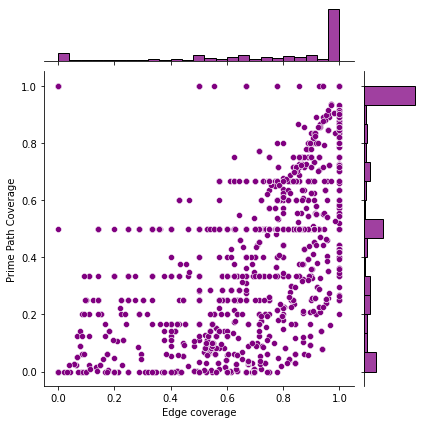

In [99]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset_original, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.show(ax)

# Características do dataset após pré-processamento

In [5]:
# REGISTROS DUPLCIADOS
dataset[dataset.duplicated()]

,Name,CountInput,CountLineCode,CountOutput,CountStmt,CountStmtDecl,CountPath,CountPathLog,CountStmtExe,Cyclomatic,...,Name.1,CountLineCode.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountPath.1,CountPathLog.1,CountStmtExe.1,Cyclomatic.1,CyclomaticStrict.1


[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

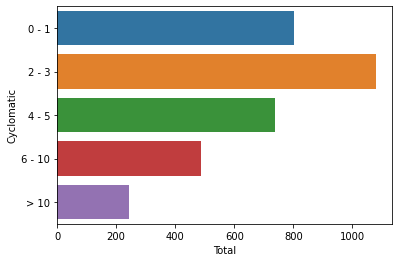

In [76]:
def get_level_of_cyclomatic(level):
    if level <= 1:
        return '0 - 1'
    elif level <= 3:
        return '2 - 3'
    elif level <= 5:
        return '4 - 5'
    elif level <= 10:
        return '6 - 10'

    #elif level <= 20:
    #    return '16 - 20'
    
    return '> 10'


d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 1', '2 - 3', '4 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

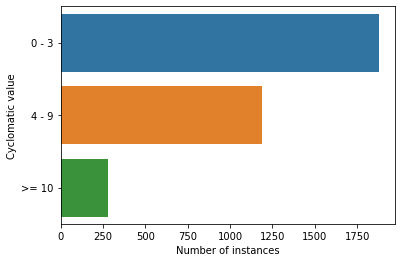

In [112]:
def get_level_of_cyclomatic(level):
    if level <= 3:
        return '0 - 3'
    elif level <= 9:
        return '4 - 9'

    return '>= 10'


d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 3', '4 - 9', '>= 10'])
ax.set(xlabel='Number of instances', ylabel='Cyclomatic value')
plt.savefig('cyclomatic-chart-preprocessing.png', dpi=300)

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

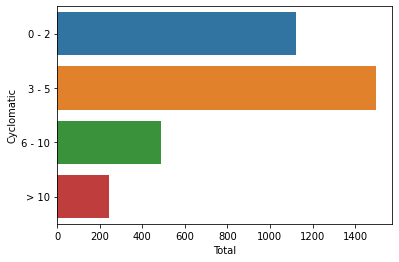

In [8]:
def get_level_of_cyclomatic(level):
    if level <= 2:
        return '0 - 2'
    elif level <= 5:
        return '3 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 2', '3 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

Dataset size:  3350
Média complexidade dataset balanceado:  4.287462686567165


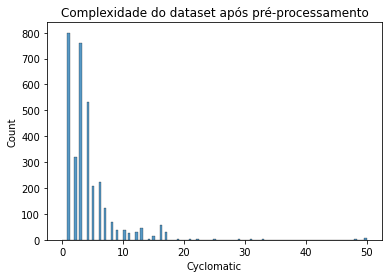

In [89]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

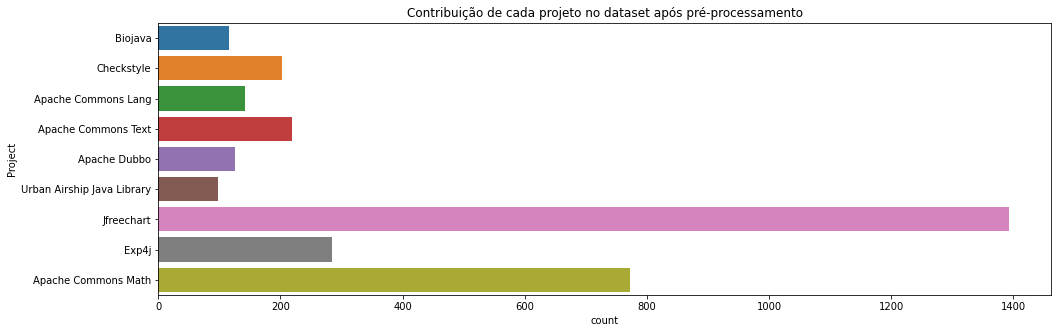

In [10]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset
d2['Project'] = dataset['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:title={'center':'Complexidade do dataset após pré-processamento por projeto'}, xlabel='count', ylabel='Project'>

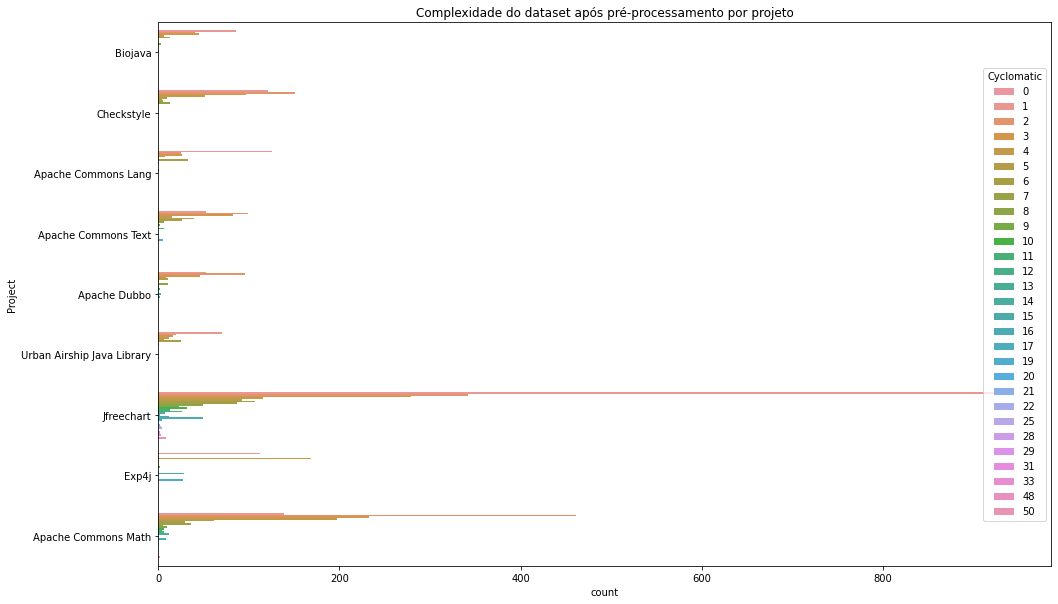

In [90]:
plt.figure(figsize=(16,10))
plt.title('Complexidade do dataset após pré-processamento por projeto')
sns.countplot(y='Project', data=d2, orient='h', hue='Cyclomatic')

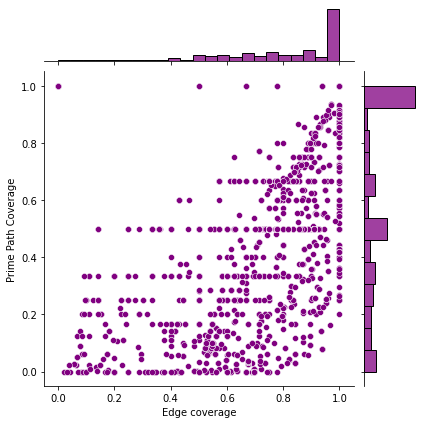

In [115]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.savefig('ec-ppc.png', dpi=300)
plt.show(ax)

<AxesSubplot:title={'center':'Correlação das métricas após pré-processamento'}>

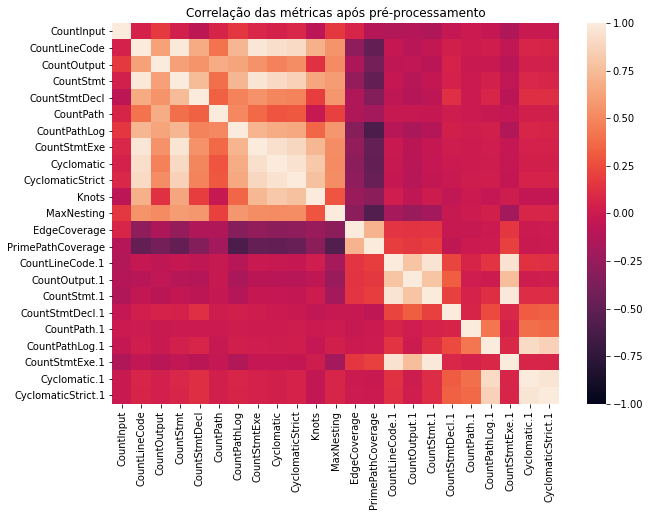

In [92]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas após pré-processamento")
sns.heatmap(dataset.corr(), vmin=-1, vmax=1)

,Metrics,Correlation
12,EdgeCoverage,0.708708
19,CountStmtExe.1,0.198990
13,CountLineCode.1,0.187873
15,CountStmt.1,0.187679
14,CountOutput.1,0.168669
18,CountPathLog.1,0.000196
21,CyclomaticStrict.1,-0.005418
17,CountPath.1,-0.006238
20,Cyclomatic.1,-0.010360
16,CountStmtDecl.1,-0.061064


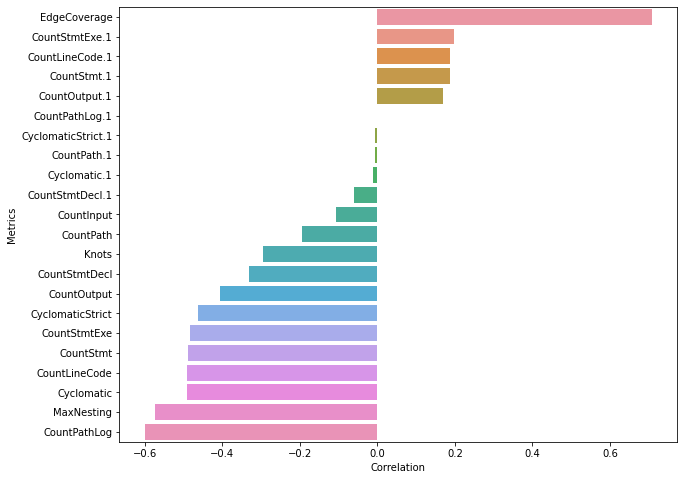

In [107]:
correlations = dataset.corr()['PrimePathCoverage']
correlations = correlations.drop('PrimePathCoverage')

metrics = correlations.index
ppc_corr = correlations.values
corr_table = pd.DataFrame(columns=['Metrics', 'Correlation'])
corr_table['Metrics'] = metrics
corr_table['Correlation'] = ppc_corr
corr_table = corr_table.sort_values(ascending=False, by='Correlation')

plt.figure(figsize=(10,8))
sns.barplot(y='Metrics', x='Correlation', data=corr_table)

display(corr_table)

In [103]:
d_groupby = d2.groupby('Project')
d_groupby['Cyclomatic'].describe()

,count,mean,std,min,25%,50%,75%,max
Project,,,,,,,,
Apache Commons Lang,220.0,2.295455,1.951227,1.0,1.0,1.0,3.0,12.0
Apache Commons Math,1213.0,3.325639,3.061036,1.0,2.0,3.0,4.0,48.0
Apache Commons Text,335.0,3.379104,2.740719,0.0,2.0,3.0,4.5,19.0
Apache Dubbo,235.0,2.910638,2.656329,1.0,2.0,2.0,3.0,16.0
Biojava,195.0,2.215385,1.654350,1.0,1.0,2.0,3.0,13.0
Checkstyle,453.0,2.505519,1.529385,1.0,1.0,2.0,3.0,8.0
Exp4j,339.0,4.814159,4.762182,1.0,1.0,4.0,4.0,17.0
Jfreechart,2203.0,3.625511,4.828016,1.0,1.0,2.0,4.0,50.0
Urban Airship Java Library,149.0,2.630872,1.953337,1.0,1.0,2.0,4.0,8.0


In [106]:
pd.DataFrame(d_groupby['CountLineCode'].sum())

,CountLineCode
Project,
Apache Commons Lang,1832
Apache Commons Math,17620
Apache Commons Text,4270
Apache Dubbo,2691
Biojava,1974
Checkstyle,5037
Exp4j,5910
Jfreechart,32571
Urban Airship Java Library,1470


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3350 entries, 1 to 5339
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                3350 non-null   object 
 1   CountInput          3350 non-null   int64  
 2   CountLineCode       3350 non-null   int64  
 3   CountOutput         3350 non-null   int64  
 4   CountStmt           3350 non-null   int64  
 5   CountStmtDecl       3350 non-null   int64  
 6   CountPath           3350 non-null   int64  
 7   CountPathLog        3350 non-null   int64  
 8   CountStmtExe        3350 non-null   int64  
 9   Cyclomatic          3350 non-null   int64  
 10  CyclomaticStrict    3350 non-null   int64  
 11  Knots               3350 non-null   int64  
 12  MaxNesting          3350 non-null   int64  
 13  EdgeCoverage        3350 non-null   float64
 14  PrimePathCoverage   3350 non-null   float64
 15  Name.1              3350 non-null   object 
 16  CountL

In [18]:
dataset.describe()

,CountInput,CountLineCode,CountOutput,CountStmt,CountStmtDecl,CountPath,CountPathLog,CountStmtExe,Cyclomatic,CyclomaticStrict,...,PrimePathCoverage,CountLineCode.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountPath.1,CountPathLog.1,CountStmtExe.1,Cyclomatic.1,CyclomaticStrict.1
count,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,...,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000
mean,24.454328,17.357015,5.738209,12.228358,3.220000,75.097015,0.576716,9.008358,4.287463,4.880896,...,0.610899,21.040299,8.970746,16.758806,4.313134,317.140299,0.074030,12.445672,1.370746,1.390746
std,42.893726,18.193012,5.304899,12.466621,3.837972,651.079019,0.700165,9.929548,4.516126,5.471484,...,0.340345,28.947072,7.953079,24.531813,3.072068,12808.478083,0.341969,24.080075,1.154209,1.224746
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,7.000000,3.000000,5.000000,1.000000,1.250000,0.000000,3.000000,2.000000,2.000000,...,0.333300,8.000000,5.000000,6.000000,3.000000,1.000000,0.000000,3.000000,1.000000,1.000000
50%,9.000000,13.000000,4.000000,9.000000,2.000000,3.000000,0.000000,6.000000,3.000000,3.000000,...,0.600000,13.000000,7.000000,10.000000,3.000000,1.000000,0.000000,6.000000,1.000000,1.000000
75%,22.000000,20.000000,7.000000,15.000000,3.000000,6.000000,1.000000,11.000000,5.000000,6.000000,...,1.000000,21.000000,10.000000,17.000000,5.000000,1.000000,0.000000,12.000000,1.000000,1.000000
max,201.000000,225.000000,58.000000,144.000000,49.000000,6912.000000,4.000000,99.000000,50.000000,72.000000,...,1.000000,273.000000,70.000000,230.000000,32.000000,524288.000000,6.000000,226.000000,20.000000,20.000000


# Funções uteis

In [5]:
k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage',
    
    # Método de teste
    'CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

previsores_sem_ec = previsores.copy()
previsores_sem_ec.remove('EdgeCoverage')

In [6]:
def feature_importance_of(regressor_model, previsores, ppc, previsores_nome):
    results = permutation_importance(regressor_model, previsores, ppc, scoring='neg_mean_squared_error')  
    importance = results.importances_mean

    return importance

In [7]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=10, apenas_escalonamento=False, display_prediction=False, display_feature_importance=False):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    error_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=['no_scaled', 'scaled']
    )
    

    if not apenas_escalonamento:
        resultados = cross_validate(
                classificador, 
                previsores_content, 
                ppc, 
                cv=k, 
                scoring=metricas_erro, 
                return_estimator=True
        )
        error_metrics_table['no_scaled']['Mean Abs Error'] = abs(resultados['test_neg_mean_absolute_error'].mean())
        error_metrics_table['no_scaled']['Mean Sqr Error'] = abs(resultados['test_neg_mean_squared_error'].mean())
        error_metrics_table['no_scaled']['Mean Sqr Log Error'] = abs(resultados['test_neg_mean_squared_log_error'].mean())
        error_metrics_table['no_scaled']['Mean Median Error'] = abs(resultados['test_neg_median_absolute_error'].mean())
        error_metrics_table['no_scaled']['R2 Score'] = abs(resultados['test_r2'].mean())
        
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    error_metrics_table['scaled']['Mean Abs Error'] = abs(resultados_escalonados['test_neg_mean_absolute_error'].mean())
    error_metrics_table['scaled']['Mean Sqr Error'] = abs(resultados_escalonados['test_neg_mean_squared_error'].mean())
    error_metrics_table['scaled']['Mean Sqr Log Error'] = abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean())
    error_metrics_table['scaled']['Mean Median Error'] = abs(resultados_escalonados['test_neg_median_absolute_error'].mean())
    error_metrics_table['scaled']['R2 Score'] = abs(resultados_escalonados['test_r2'].mean())
    
    if display_prediction:
        k_current = 0
        for estimator in resultados_escalonados['estimator']:
            ppc_predict = estimator.predict(escalonador(previsores_content))
            predict_table = pd.DataFrame(index=[i for i in range(len(ppc_predict))],columns=['PPC correct', 'PPC predict', 'MAE'])

            for i in range(len(ppc_predict)):
                predict_table['PPC correct'][i] = ppc[i]
                predict_table['PPC predict'][i] = ppc_predict[i]
                predict_table['MAE'][i] = abs(ppc[i] - ppc_predict[i])
                #print(ppc_predict[i], ppc[i])
            print('k:', k_current)
            display(predict_table)
            k_current += 1
    
    if display_feature_importance:
        k_current = 0
        columns = [i for i in range(k)]
        columns.append('Mean')
        fi_scaled_table = pd.DataFrame(columns=columns, index=d[previsores].columns)
        
        for estimator in resultados_escalonados['estimator']:
            fi_scaled_table[k_current] = feature_importance_of(
                estimator, escalonador(previsores_content), ppc, d[previsores].columns
            )
            k_current += 1
            
        for i in range(fi_scaled_table.shape[0]):
            fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()
        

        fi_final = pd.DataFrame(columns=['Metrics', 'Importance'])
        fi_final['Metrics'] = fi_scaled_table.index.values
        fi_final['Importance'] = fi_scaled_table['Mean'].values

        fi_final = fi_final.sort_values(ascending=False, by='Importance')
        display(fi_final)
        plt.figure(figsize=(12,8))
        plt.title("Feature importance - K = " + str(k) + " - Mean")
        plt.axis([0, fi_final['Importance'].values.max(), 0, len(fi_final.index.values)])
        sns.barplot(y=fi_final['Metrics'].values, x=fi_final['Importance'].values, orient='h')
        plt.show()

    
    return error_metrics_table

In [8]:
def feature_importance(classificador, d = dataset, prev = previsores):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    previsores_content = d[prev].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    print(importance_dataset['mean'].sort_values(ascending=False))
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()

In [9]:
def estimator_metrics_to_dataframe(estimator_results, dataframe):
    dataframe['Mean']['Mean Abs Error'] = estimator_results.iloc[0,:-1].mean()
    dataframe['Mean']['Mean Sqr Error'] = estimator_results.iloc[1,:-1].mean()
    dataframe['Mean']['Mean Sqr Log Error'] = estimator_results.iloc[2,:-1].mean()
    dataframe['Mean']['Mean Median Error'] = estimator_results.iloc[3,:-1].mean()
    dataframe['Mean']['R2 Score'] = estimator_results.iloc[4,:-1].mean()

# Experimentos

## Linear Regression

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.112894
19,CountStmtExe.1,0.00128798
14,CountOutput.1,7.4514e-06
13,CountLineCode.1,3.4024e-08
0,CountInput,0
10,Knots,0
20,Cyclomatic.1,0
16,CountStmtDecl.1,0
15,CountStmt.1,0
1,CountLineCode,0


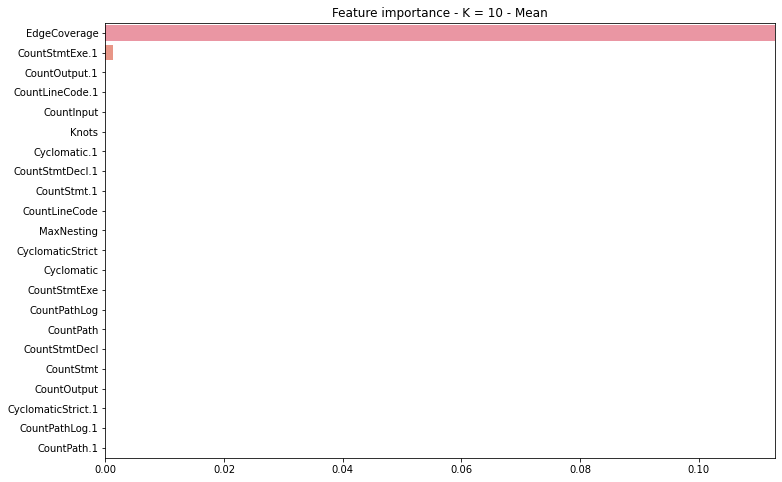

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [24]:
evaluate(previsores, LinearRegression(positive=True), display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
18,CountStmtExe.1,0.00614666
13,CountOutput.1,0.00033824
12,CountLineCode.1,3.58007e-06
0,CountInput,0
1,CountLineCode,0
19,Cyclomatic.1,0
17,CountPathLog.1,0
15,CountStmtDecl.1,0
14,CountStmt.1,0
11,MaxNesting,0


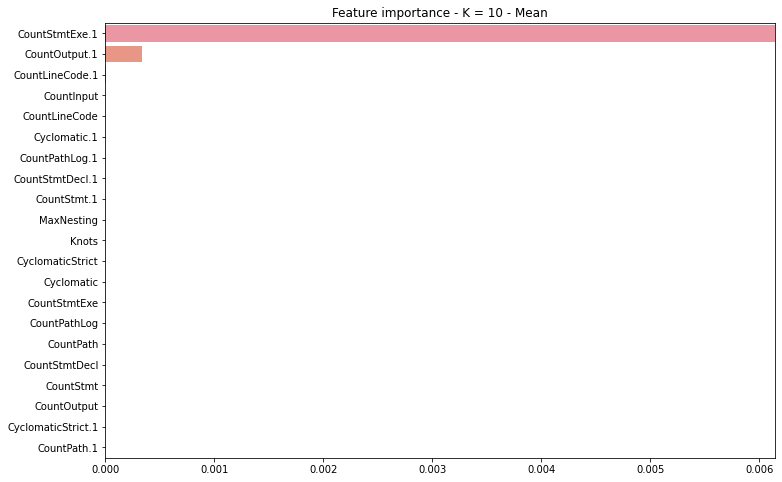

,no_scaled,scaled
Mean Abs Error,0.297273,0.297273
Mean Sqr Error,0.130122,0.130122
Mean Sqr Log Error,0.0507882,0.0507882
Mean Median Error,0.311615,0.311615
R2 Score,0.177976,0.177976


In [25]:
evaluate(previsores_sem_ec, LinearRegression(positive=True), display_feature_importance=True)

### Com EC

In [26]:
error_metrics_table = pd.DataFrame(
    index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
    columns=previsores
)

for previsor in previsores:
    print('PREVISOR ', previsor)
    metrics = evaluate([
        previsor
    ], LinearRegression(positive=True), dataset)
    error_metrics_table[previsor] = metrics['scaled']
    display(metrics)
    print('\n')

PREVISOR  CountInput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountOutput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmt


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtDecl


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPathLog


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtExe


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Cyclomatic


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CyclomaticStrict


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Knots


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  MaxNesting


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  EdgeCoverage


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN




PREVISOR  CountLineCode.1


,no_scaled,scaled
Mean Abs Error,0.294229,0.294229
Mean Sqr Error,0.113319,0.113319
Mean Sqr Log Error,0.0494709,0.0494709
Mean Median Error,0.307604,0.307604
R2 Score,0.0317703,0.0317703




PREVISOR  CountOutput.1


,no_scaled,scaled
Mean Abs Error,0.294844,0.294844
Mean Sqr Error,0.114245,0.114245
Mean Sqr Log Error,0.0499953,0.0499953
Mean Median Error,0.307665,0.307665
R2 Score,0.0398916,0.0398916




PREVISOR  CountStmt.1


,no_scaled,scaled
Mean Abs Error,0.294491,0.294491
Mean Sqr Error,0.113397,0.113397
Mean Sqr Log Error,0.0494741,0.0494741
Mean Median Error,0.308865,0.308865
R2 Score,0.0299882,0.0299882




PREVISOR  CountStmtDecl.1


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath.1


,no_scaled,scaled
Mean Abs Error,0.330616,0.330616
Mean Sqr Error,1.48944,1.48944
Mean Sqr Log Error,0.0581882,0.0581882
Mean Median Error,0.32638,0.32638
R2 Score,12.1851,12.1851




PREVISOR  CountPathLog.1


,no_scaled,scaled
Mean Abs Error,0.302088,0.302088
Mean Sqr Error,0.116794,0.116794
Mean Sqr Log Error,0.050945,0.050945
Mean Median Error,0.326448,0.326448
R2 Score,0.052479,0.052479




PREVISOR  CountStmtExe.1


,no_scaled,scaled
Mean Abs Error,0.293639,0.293639
Mean Sqr Error,0.113051,0.113051
Mean Sqr Log Error,0.0492599,0.0492599
Mean Median Error,0.311154,0.311154
R2 Score,0.0261972,0.0261972




PREVISOR  Cyclomatic.1


,no_scaled,scaled
Mean Abs Error,0.301998,0.301998
Mean Sqr Error,0.116761,0.116761
Mean Sqr Log Error,0.0509288,0.0509288
Mean Median Error,0.325733,0.325733
R2 Score,0.0521811,0.0521811




PREVISOR  CyclomaticStrict.1


,no_scaled,scaled
Mean Abs Error,0.302071,0.302071
Mean Sqr Error,0.11679,0.11679
Mean Sqr Log Error,0.0509428,0.0509428
Mean Median Error,0.326083,0.326083
R2 Score,0.0524417,0.0524417


C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression - R2 Score'}>

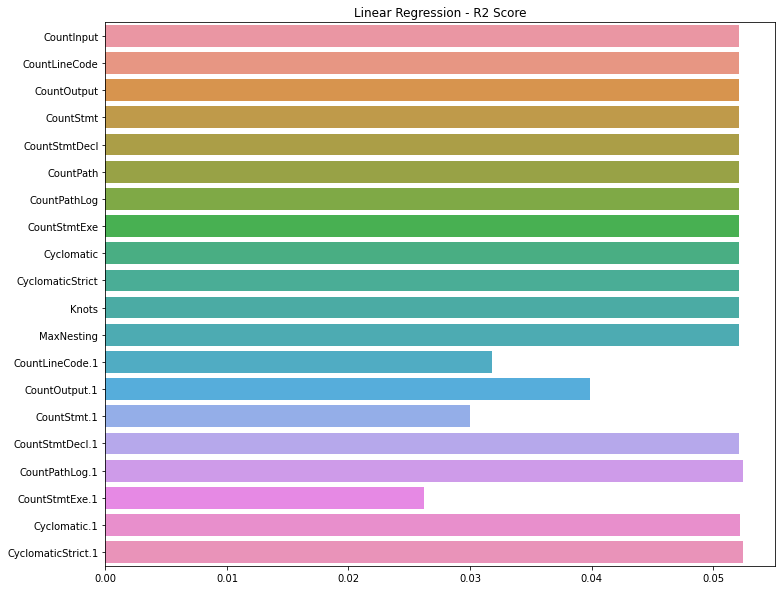

In [27]:
error_metrics = error_metrics_table.iloc[-1,:].dropna()
error_metrics = error_metrics[error_metrics < 1]
y_axis = error_metrics.values
x_axis = error_metrics.index.values
plt.figure(figsize=(12,10))
plt.title('Linear Regression - R2 Score')
sns.barplot(y_axis, x_axis)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression - MSE'}>

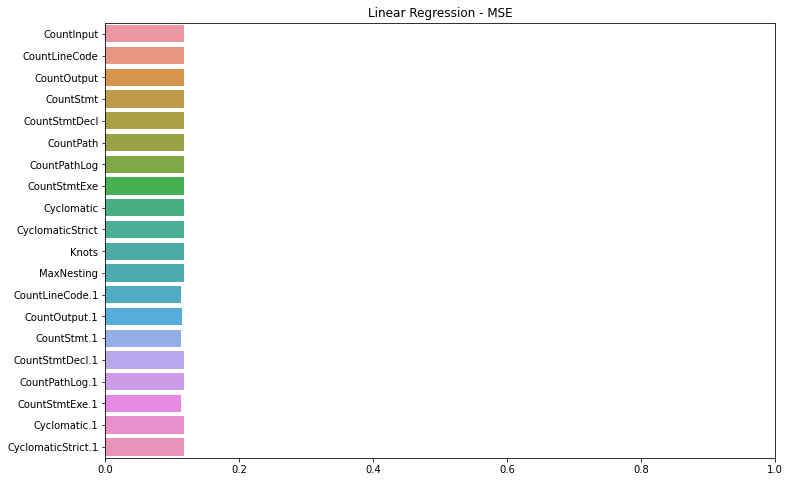

In [28]:
error_metrics = error_metrics_table.iloc[1,:].dropna()
error_metrics = error_metrics[error_metrics < 1]
y_axis = error_metrics.values
x_axis = error_metrics.index.values
plt.figure(figsize=(12,8))
plt.axis([0, 1, 0, len(x_axis)])
plt.title('Linear Regression - MSE')
sns.barplot(y_axis, x_axis)

In [29]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.206974,0.206974
Mean Sqr Error,0.0620772,0.0620772
Mean Sqr Log Error,0.029046,0.029046
Mean Median Error,0.212136,0.212136
R2 Score,0.441571,0.441571


In [30]:
evaluate([
    'MaxNesting'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.495413,0.495413
Mean Sqr Error,0.377472,0.377472
Mean Sqr Log Error,0.178821,0.178821
Mean Median Error,0.406899,0.406899
R2 Score,2.51427,2.51427


### Sem EC

In [31]:
error_metrics_table = pd.DataFrame(
    index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
    columns=previsores
)

for previsor in previsores:
    if previsor == 'EdgeCoverage':
        continue
        
    print('PREVISOR ', previsor)
    metrics = evaluate([
        previsor
    ], LinearRegression(positive=True), dataset)
    error_metrics_table[previsor] = metrics['scaled']
    display(metrics)
    print('\n')

PREVISOR  CountInput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountOutput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmt


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtDecl


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPathLog


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtExe


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Cyclomatic


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CyclomaticStrict


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Knots


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  MaxNesting


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode.1


,no_scaled,scaled
Mean Abs Error,0.294229,0.294229
Mean Sqr Error,0.113319,0.113319
Mean Sqr Log Error,0.0494709,0.0494709
Mean Median Error,0.307604,0.307604
R2 Score,0.0317703,0.0317703




PREVISOR  CountOutput.1


,no_scaled,scaled
Mean Abs Error,0.294844,0.294844
Mean Sqr Error,0.114245,0.114245
Mean Sqr Log Error,0.0499953,0.0499953
Mean Median Error,0.307665,0.307665
R2 Score,0.0398916,0.0398916




PREVISOR  CountStmt.1


,no_scaled,scaled
Mean Abs Error,0.294491,0.294491
Mean Sqr Error,0.113397,0.113397
Mean Sqr Log Error,0.0494741,0.0494741
Mean Median Error,0.308865,0.308865
R2 Score,0.0299882,0.0299882




PREVISOR  CountStmtDecl.1


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath.1


,no_scaled,scaled
Mean Abs Error,0.330616,0.330616
Mean Sqr Error,1.48944,1.48944
Mean Sqr Log Error,0.0581882,0.0581882
Mean Median Error,0.32638,0.32638
R2 Score,12.1851,12.1851




PREVISOR  CountPathLog.1


,no_scaled,scaled
Mean Abs Error,0.302088,0.302088
Mean Sqr Error,0.116794,0.116794
Mean Sqr Log Error,0.050945,0.050945
Mean Median Error,0.326448,0.326448
R2 Score,0.052479,0.052479




PREVISOR  CountStmtExe.1


,no_scaled,scaled
Mean Abs Error,0.293639,0.293639
Mean Sqr Error,0.113051,0.113051
Mean Sqr Log Error,0.0492599,0.0492599
Mean Median Error,0.311154,0.311154
R2 Score,0.0261972,0.0261972




PREVISOR  Cyclomatic.1


,no_scaled,scaled
Mean Abs Error,0.301998,0.301998
Mean Sqr Error,0.116761,0.116761
Mean Sqr Log Error,0.0509288,0.0509288
Mean Median Error,0.325733,0.325733
R2 Score,0.0521811,0.0521811




PREVISOR  CyclomaticStrict.1


,no_scaled,scaled
Mean Abs Error,0.302071,0.302071
Mean Sqr Error,0.11679,0.11679
Mean Sqr Log Error,0.0509428,0.0509428
Mean Median Error,0.326083,0.326083
R2 Score,0.0524417,0.0524417


### Apenas EC

In [32]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.206974,0.206974
Mean Sqr Error,0.0620772,0.0620772
Mean Sqr Log Error,0.029046,0.029046
Mean Median Error,0.212136,0.212136
R2 Score,0.441571,0.441571


## SVR

In [33]:
def evaluate_svr(metrics, epsilon = 0.1, tot_seeds=0, display_feature_importance=False):
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=[0, 'Mean']
    )
    
    error_scaled_metrics_table.index.name = 'Error metrics'
    error_scaled_metrics_table.columns.name = 'Seed'

    error_metrics = evaluate(metrics, SVR(epsilon=epsilon), dataset, apenas_escalonamento=True, display_feature_importance=display_feature_importance)
    error_scaled_metrics_table[0] = error_metrics['scaled']
    estimator_metrics_to_dataframe(error_metrics, error_scaled_metrics_table)

    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

,Metrics,Importance
12,EdgeCoverage,0.0858965
6,CountPathLog,0.00870845
11,MaxNesting,0.00430722
7,CountStmtExe,0.00382408
3,CountStmt,0.00333331
4,CountStmtDecl,0.0029799
9,CyclomaticStrict,0.00278582
15,CountStmt.1,0.00104377
19,CountStmtExe.1,0.00100108
8,Cyclomatic,0.000949374


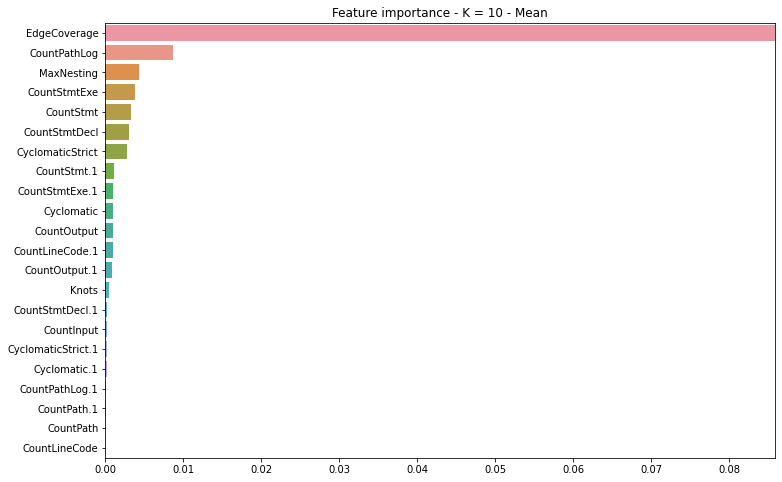

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [34]:
evaluate_svr(previsores, epsilon=0.3, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0236545
6,CountPathLog,0.0197674
8,Cyclomatic,0.0150978
7,CountStmtExe,0.00959733
1,CountLineCode,0.0067273
0,CountInput,0.00636571
13,CountOutput.1,0.00505992
14,CountStmt.1,0.00498466
18,CountStmtExe.1,0.00488976
12,CountLineCode.1,0.00439583


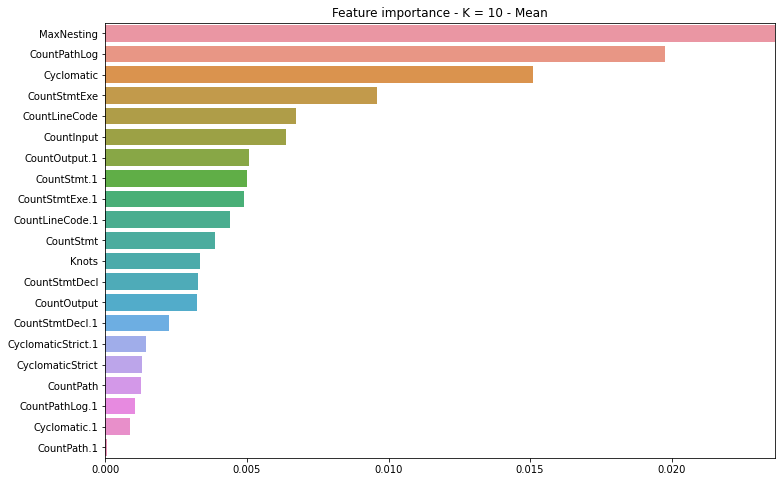

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218093,NaN
Mean Sqr Error,0.0626579,NaN
Mean Sqr Log Error,0.0279004,NaN
Mean Median Error,0.20869,NaN
R2 Score,0.421141,NaN


In [35]:
evaluate_svr(previsores_sem_ec, epsilon=0.3, display_feature_importance=True)

### Com EC

In [36]:
evaluate_svr(previsores, epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.229429,NaN
Mean Sqr Error,0.0695661,NaN
Mean Sqr Log Error,0.0278945,NaN
Mean Median Error,0.236011,NaN
R2 Score,0.359841,NaN


In [37]:
evaluate_svr([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.185766,NaN
Mean Sqr Error,0.0468584,NaN
Mean Sqr Log Error,0.0196152,NaN
Mean Median Error,0.203179,NaN
R2 Score,0.574105,NaN


In [38]:
evaluate_svr([
    'Cyclomatic', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218685,NaN
Mean Sqr Error,0.0622643,NaN
Mean Sqr Log Error,0.0242962,NaN
Mean Median Error,0.222261,NaN
R2 Score,0.4266,NaN


In [39]:
evaluate_svr([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.2157,NaN
Mean Sqr Error,0.0637464,NaN
Mean Sqr Log Error,0.0285504,NaN
Mean Median Error,0.195121,NaN
R2 Score,0.410263,NaN


In [40]:
evaluate_svr([
    'CountInput','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting',
    
    'CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.246073,NaN
Mean Sqr Error,0.0790754,NaN
Mean Sqr Log Error,0.0347405,NaN
Mean Median Error,0.245945,NaN
R2 Score,0.285856,NaN


In [41]:
evaluate_svr([
    'Cyclomatic', 
    'CountOutput',
    'EdgeCoverage'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.22054,NaN
Mean Sqr Error,0.0648962,NaN
Mean Sqr Log Error,0.0252986,NaN
Mean Median Error,0.229466,NaN
R2 Score,0.403778,NaN


### Sem EC

In [42]:
evaluate_svr(previsores_sem_ec, epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218093,NaN
Mean Sqr Error,0.0626579,NaN
Mean Sqr Log Error,0.0279004,NaN
Mean Median Error,0.20869,NaN
R2 Score,0.421141,NaN


### Apenas EC

In [43]:
evaluate_svr([
    'EdgeCoverage',
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.210894,NaN
Mean Sqr Error,0.0587562,NaN
Mean Sqr Log Error,0.0238038,NaN
Mean Median Error,0.236372,NaN
R2 Score,0.459563,NaN


## Neural network

In [44]:
def evaluate_neural_network(metrics, epsilon, tot_seeds=0, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, MLPRegressor(epsilon=epsilon, random_state=i), dataset, apenas_escalonamento=True, display_feature_importance=display_feature_importance)
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

In [45]:
#evaluate_neural_network(previsores, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0179343
6,CountPathLog,0.0126583
7,CountStmtExe,0.0027116
9,CyclomaticStrict,0.001445
10,Knots,0.00119342
3,CountStmt,0.00110103
12,CountLineCode.1,0.00103448
2,CountOutput,0.000946382
1,CountLineCode,0.00078768
14,CountStmt.1,0.00074113


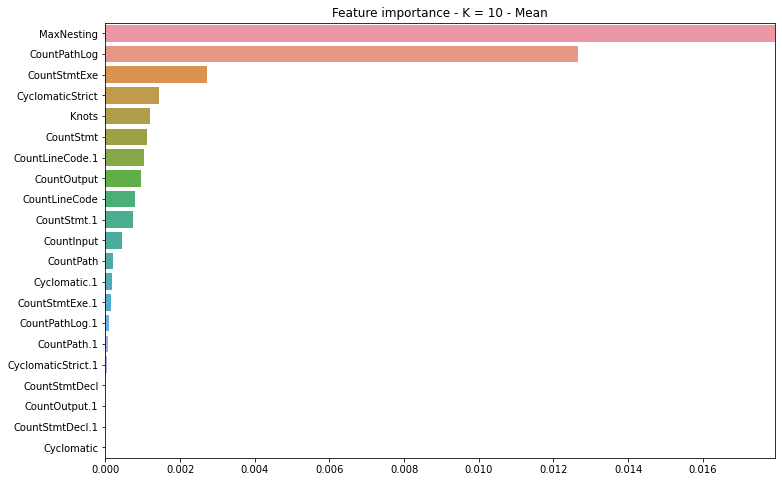

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.243107,0.243107
Mean Sqr Error,0.0774932,0.0774932
Mean Sqr Log Error,0.034324,0.034324
Mean Median Error,0.243669,0.243669
R2 Score,0.297552,0.297552


In [46]:
evaluate_neural_network(previsores_sem_ec, epsilon=0.3, display_feature_importance=True)

### Com EC

In [47]:
evaluate_neural_network(previsores, epsilon=0.8)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.233972,0.233972
Mean Sqr Error,0.0708001,0.0708001
Mean Sqr Log Error,0.0319111,0.0319111
Mean Median Error,0.239292,0.239292
R2 Score,0.373508,0.373508


### Sem EC

In [48]:
evaluate_neural_network(previsores_sem_ec, epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.243107,0.243107
Mean Sqr Error,0.0774932,0.0774932
Mean Sqr Log Error,0.034324,0.034324
Mean Median Error,0.243669,0.243669
R2 Score,0.297552,0.297552


### Apenas EC

In [49]:
evaluate_neural_network([
    'EdgeCoverage'
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.241533,0.241533
Mean Sqr Error,0.0783181,0.0783181
Mean Sqr Log Error,0.0353284,0.0353284
Mean Median Error,0.258806,0.258806
R2 Score,0.304758,0.304758


## Random forest

In [25]:
def evaluate_random_forest(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.128007
3,CountStmt,0.0149946
5,CountPath,0.00970707
10,Knots,0.00581584
2,CountOutput,0.00547643
7,CountStmtExe,0.00291489
4,CountStmtDecl,0.00257792
1,CountLineCode,0.00249003
11,MaxNesting,0.00196481
0,CountInput,0.00188358


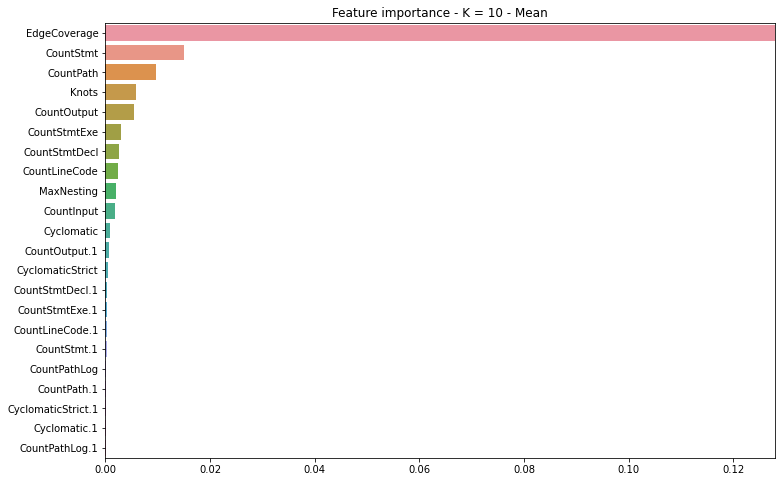

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0786762,0.0786762
Mean Sqr Error,0.0188811,0.0188811
Mean Sqr Log Error,0.00903727,0.00903727
Mean Median Error,0.034867,0.034867
R2 Score,0.826749,0.826749


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0787833,0.0787833
Mean Sqr Error,0.0189386,0.0189386
Mean Sqr Log Error,0.00906076,0.00906076
Mean Median Error,0.0352914,0.0352914
R2 Score,0.82617,0.82617


In [51]:
evaluate_random_forest(previsores, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
5,CountPath,0.0550445
1,CountLineCode,0.0172832
11,MaxNesting,0.0158091
18,CountStmtExe.1,0.011718
13,CountOutput.1,0.0099777
0,CountInput,0.00882591
3,CountStmt,0.00839743
7,CountStmtExe,0.00773159
15,CountStmtDecl.1,0.00745115
2,CountOutput,0.00553488


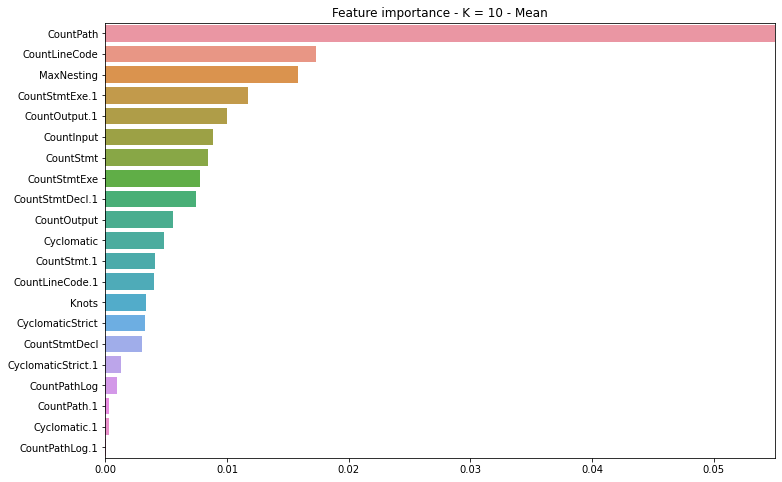

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147809,0.147809
Mean Sqr Error,0.0481227,0.0481227
Mean Sqr Log Error,0.0219381,0.0219381
Mean Median Error,0.109017,0.109017
R2 Score,0.542421,0.542421


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147786,0.147786
Mean Sqr Error,0.0482513,0.0482513
Mean Sqr Log Error,0.021994,0.021994
Mean Median Error,0.107399,0.107399
R2 Score,0.541412,0.541412


In [52]:
evaluate_random_forest(previsores_sem_ec, display_feature_importance=True)

-----< SEM ESCALONAMENTO >-----


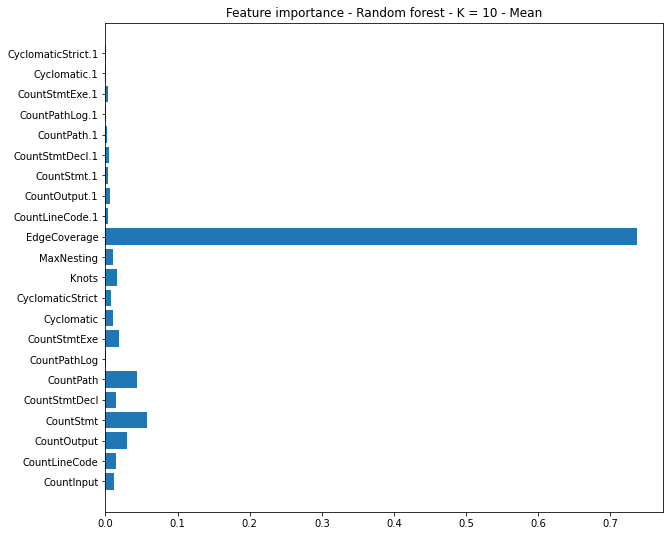



-----< COM ESCALONAMENTO >-----
EdgeCoverage          0.736436
CountStmt             0.057850
CountPath             0.041685
CountOutput           0.030715
CountStmtExe          0.018766
Knots                 0.015542
CountStmtDecl         0.015474
CountLineCode         0.014988
CountInput            0.012012
Cyclomatic            0.011003
MaxNesting            0.010107
CyclomaticStrict      0.008842
CountOutput.1         0.005989
CountStmtDecl.1       0.004104
CountLineCode.1       0.003894
CountStmtExe.1        0.003838
CountStmt.1           0.003376
CountPath.1           0.001543
CountPathLog          0.001525
CyclomaticStrict.1    0.000973
Cyclomatic.1          0.000835
CountPathLog.1        0.000504
Name: mean, dtype: float64


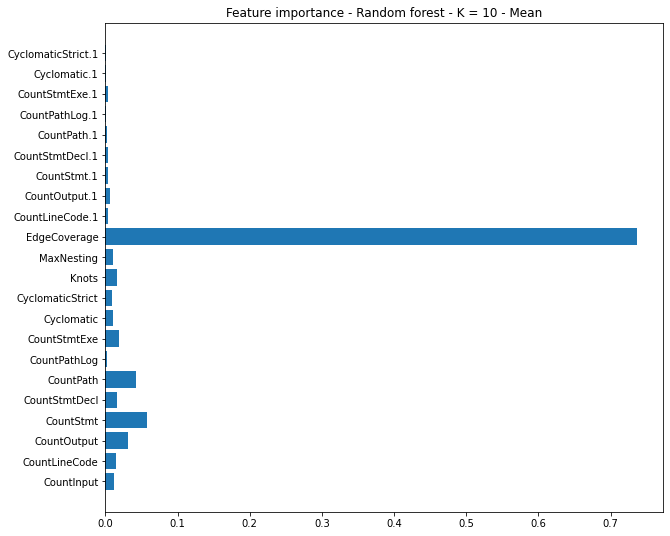

In [53]:
feature_importance(RandomForestRegressor(),dataset)

### Com EC

-----< SEM ESCALONAMENTO >-----


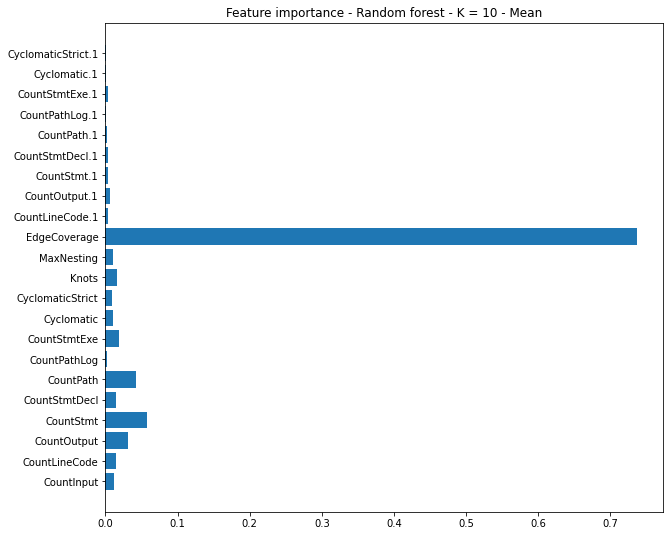



-----< COM ESCALONAMENTO >-----
EdgeCoverage          0.736387
CountStmt             0.058045
CountPath             0.042119
CountOutput           0.030383
CountStmtExe          0.018342
Knots                 0.015660
CountLineCode         0.015333
CountStmtDecl         0.015309
CountInput            0.012241
Cyclomatic            0.010972
MaxNesting            0.010257
CyclomaticStrict      0.008127
CountOutput.1         0.006296
CountStmtDecl.1       0.004145
CountLineCode.1       0.003838
CountStmtExe.1        0.003646
CountStmt.1           0.003379
CountPathLog          0.001781
CountPath.1           0.001489
CyclomaticStrict.1    0.000904
Cyclomatic.1          0.000845
CountPathLog.1        0.000500
Name: mean, dtype: float64


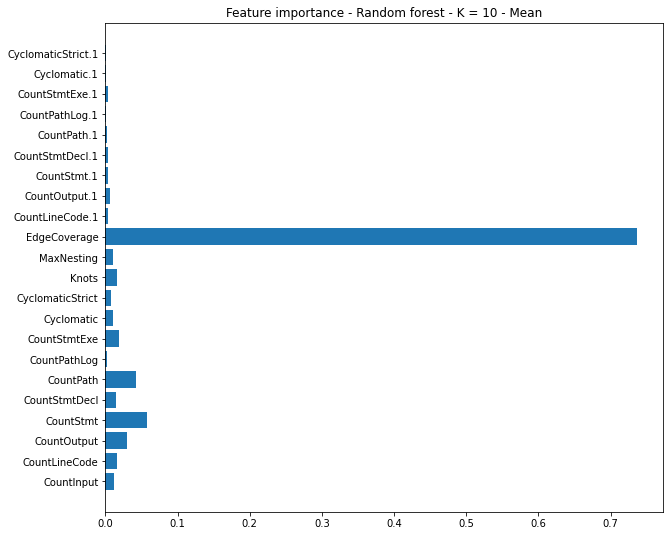

In [54]:
feature_importance(RandomForestRegressor())

In [55]:
evaluate_random_forest(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0786762,0.0786762
Mean Sqr Error,0.0188811,0.0188811
Mean Sqr Log Error,0.00903727,0.00903727
Mean Median Error,0.034867,0.034867
R2 Score,0.826749,0.826749


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0787833,0.0787833
Mean Sqr Error,0.0189386,0.0189386
Mean Sqr Log Error,0.00906076,0.00906076
Mean Median Error,0.0352914,0.0352914
R2 Score,0.82617,0.82617


In [56]:
evaluate_random_forest([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


In [57]:
evaluate_random_forest([
    'CountPath', 'CountStmtExe.1', 'CountInput', 'CountOutput', 'CountOutput.1', 'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0876215,0.0876215
Mean Sqr Error,0.0215344,0.0215344
Mean Sqr Log Error,0.0101418,0.0101418
Mean Median Error,0.0429287,0.0429287
R2 Score,0.798505,0.798505


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0875951,0.0875951
Mean Sqr Error,0.0215646,0.0215646
Mean Sqr Log Error,0.010159,0.010159
Mean Median Error,0.0425257,0.0425257
R2 Score,0.798199,0.798199


### Sem EC

-----< SEM ESCALONAMENTO >-----


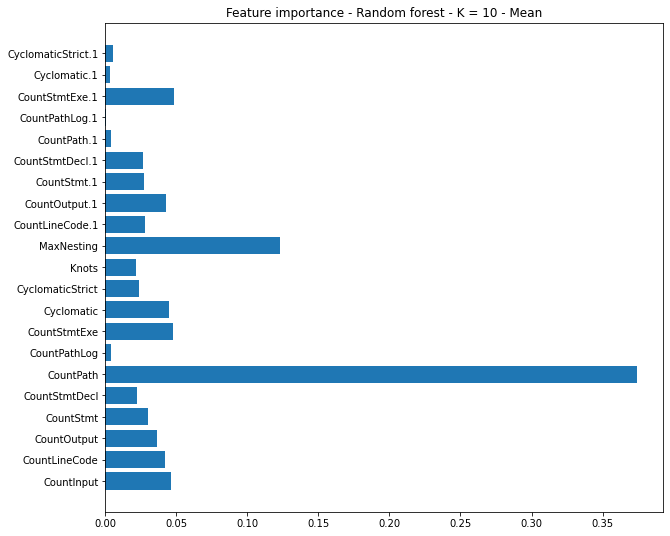



-----< COM ESCALONAMENTO >-----
CountPath             0.372770
MaxNesting            0.123629
Cyclomatic            0.048604
CountStmtExe.1        0.047891
CountInput            0.046386
CountStmtExe          0.046191
CountOutput.1         0.042582
CountLineCode         0.042388
CountOutput           0.035995
CountStmt             0.029958
CountLineCode.1       0.028381
CountStmt.1           0.026880
CountStmtDecl.1       0.026712
CountStmtDecl         0.021700
Knots                 0.021628
CyclomaticStrict      0.021458
CyclomaticStrict.1    0.005642
CountPathLog          0.004337
CountPath.1           0.003437
Cyclomatic.1          0.002767
CountPathLog.1        0.000663
Name: mean, dtype: float64


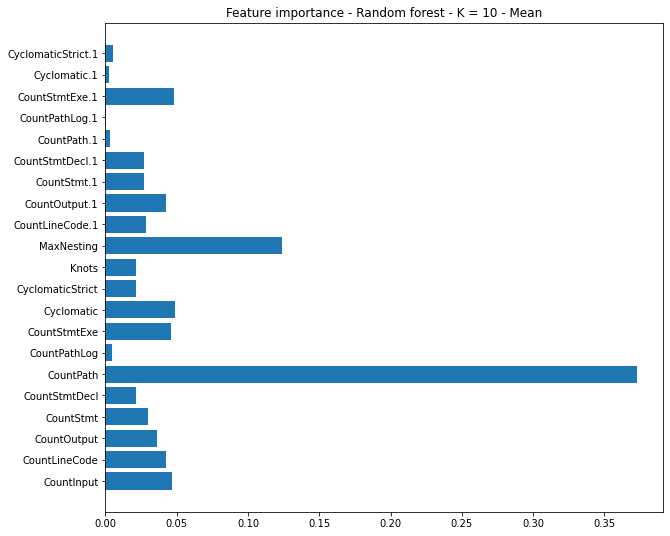

In [58]:
feature_importance(RandomForestRegressor(), prev=previsores_sem_ec)

In [59]:
evaluate_random_forest(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147809,0.147809
Mean Sqr Error,0.0481227,0.0481227
Mean Sqr Log Error,0.0219381,0.0219381
Mean Median Error,0.109017,0.109017
R2 Score,0.542421,0.542421


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147786,0.147786
Mean Sqr Error,0.0482513,0.0482513
Mean Sqr Log Error,0.021994,0.021994
Mean Median Error,0.107399,0.107399
R2 Score,0.541412,0.541412


### Apenas EC

In [60]:
evaluate_random_forest([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


## Naive bayes

**Aparentemente, não é compatível com variavel dependente como float**

In [61]:
def evaluate_nb(metrics, tot_seeds=0):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, GaussianNB(var_smoothing =0.00000000001), dataset)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

### Com EC

In [62]:
evaluate([
    'EdgeCoverage'
], GaussianNB(var_smoothing=1e-5))

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [63]:
evaluate_nb([
    'CountPath', 'CountStmtExe.1', 'CountInput', 'CountOutput', 'CountOutput.1', 'EdgeCoverage'
])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni

-----< SEM ESCALONAMENTO >-----


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni

Seed,0,Mean
Error Metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


### Sem EC

## KNeighborsRegressor

In [64]:
def evaluate_knr(metrics, tot_seeds=0, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, KNeighborsRegressor(), dataset, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.103965
6,CountPathLog,0.0185817
11,MaxNesting,0.01429
0,CountInput,0.00972261
2,CountOutput,0.00335614
4,CountStmtDecl,0.0022664
14,CountOutput.1,0.00214189
16,CountStmtDecl.1,0.00194405
10,Knots,0.0012221
7,CountStmtExe,0.000864431


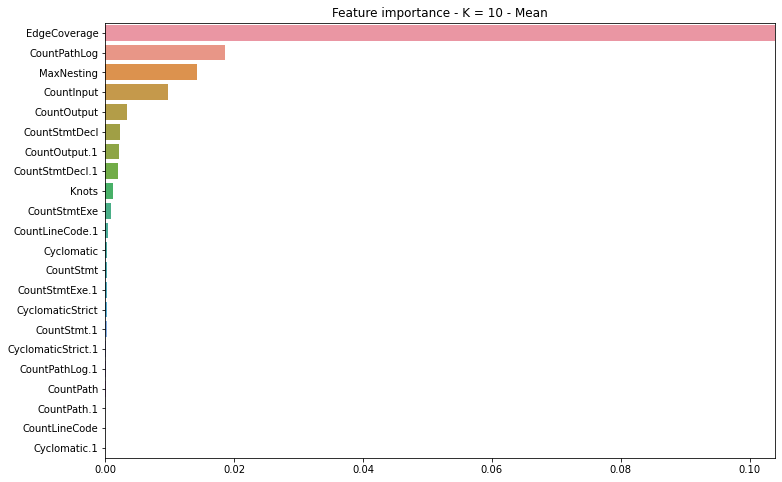

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.168141,0.168141
Mean Sqr Error,0.0615175,0.0615175
Mean Sqr Log Error,0.0274799,0.0274799
Mean Median Error,0.115594,0.115594
R2 Score,0.413543,0.413543


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0918171,0.0918171
Mean Sqr Error,0.0250757,0.0250757
Mean Sqr Log Error,0.0122085,0.0122085
Mean Median Error,0.04083,0.04083
R2 Score,0.768497,0.768497


In [65]:
evaluate_knr(previsores, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0616253
6,CountPathLog,0.0557813
0,CountInput,0.0154896
2,CountOutput,0.00911925
15,CountStmtDecl.1,0.00909707
13,CountOutput.1,0.00783307
4,CountStmtDecl,0.00657658
10,Knots,0.0058073
7,CountStmtExe,0.00353074
14,CountStmt.1,0.00350326


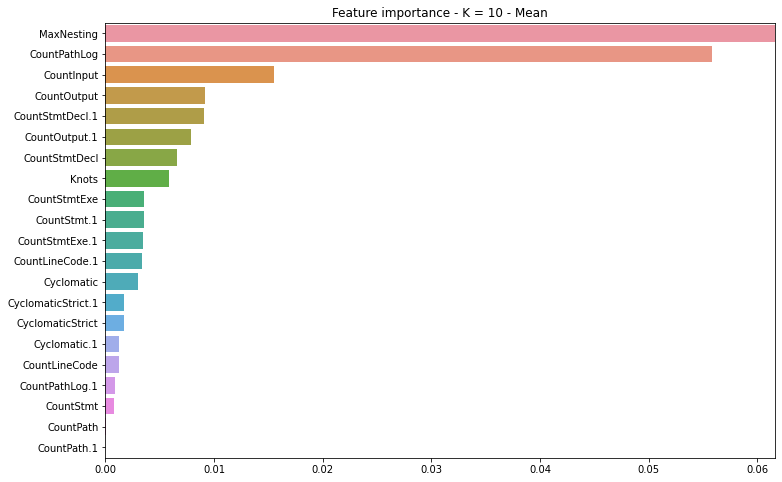

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.170081,0.170081
Mean Sqr Error,0.0626859,0.0626859
Mean Sqr Log Error,0.0279984,0.0279984
Mean Median Error,0.115668,0.115668
R2 Score,0.402208,0.402208


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.162846,0.162846
Mean Sqr Error,0.0620222,0.0620222
Mean Sqr Log Error,0.0284736,0.0284736
Mean Median Error,0.106012,0.106012
R2 Score,0.390778,0.390778


In [66]:
evaluate_knr(previsores_sem_ec, display_feature_importance=True)

### Com EC

In [67]:
evaluate_knr(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.168141,0.168141
Mean Sqr Error,0.0615175,0.0615175
Mean Sqr Log Error,0.0274799,0.0274799
Mean Median Error,0.115594,0.115594
R2 Score,0.413543,0.413543


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0918171,0.0918171
Mean Sqr Error,0.0250757,0.0250757
Mean Sqr Log Error,0.0122085,0.0122085
Mean Median Error,0.04083,0.04083
R2 Score,0.768497,0.768497


### Sem EC

In [68]:
evaluate_knr(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.170081,0.170081
Mean Sqr Error,0.0626859,0.0626859
Mean Sqr Log Error,0.0279984,0.0279984
Mean Median Error,0.115668,0.115668
R2 Score,0.402208,0.402208


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.162846,0.162846
Mean Sqr Error,0.0620222,0.0620222
Mean Sqr Log Error,0.0284736,0.0284736
Mean Median Error,0.106012,0.106012
R2 Score,0.390778,0.390778


### Apenas EC

In [69]:
evaluate_knr([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.119735,0.119735
Mean Sqr Error,0.0361383,0.0361383
Mean Sqr Log Error,0.0168497,0.0168497
Mean Median Error,0.071106,0.071106
R2 Score,0.664289,0.664289


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.119735,0.119735
Mean Sqr Error,0.0361383,0.0361383
Mean Sqr Log Error,0.0168497,0.0168497
Mean Median Error,0.071106,0.071106
R2 Score,0.664289,0.664289


# Feature importance dos melhores modelos

## SCM

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
5,CountPath,0.0551071
1,CountLineCode,0.0172435
11,MaxNesting,0.0156511
18,CountStmtExe.1,0.0117184
13,CountOutput.1,0.00994456
0,CountInput,0.00886507
3,CountStmt,0.00843744
7,CountStmtExe,0.00772947
15,CountStmtDecl.1,0.00741695
2,CountOutput,0.00556354


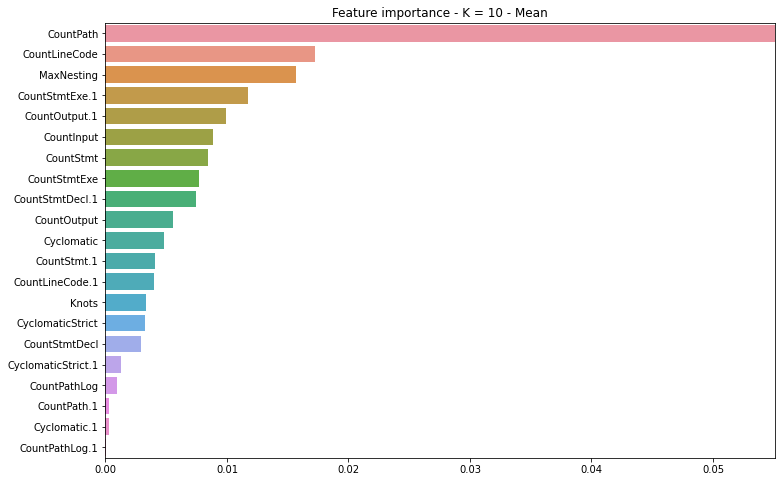

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147809,0.147809
Mean Sqr Error,0.0481227,0.0481227
Mean Sqr Log Error,0.0219381,0.0219381
Mean Median Error,0.109017,0.109017
R2 Score,0.542421,0.542421


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147786,0.147786
Mean Sqr Error,0.0482513,0.0482513
Mean Sqr Log Error,0.021994,0.021994
Mean Median Error,0.107399,0.107399
R2 Score,0.541412,0.541412


In [108]:
evaluate_random_forest(previsores_sem_ec, display_feature_importance=True)

## SCM + EC

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.127966
3,CountStmt,0.0150204
5,CountPath,0.00977109
10,Knots,0.00582382
2,CountOutput,0.00548309
7,CountStmtExe,0.00290732
4,CountStmtDecl,0.00259455
1,CountLineCode,0.00248615
11,MaxNesting,0.00195839
0,CountInput,0.00186723


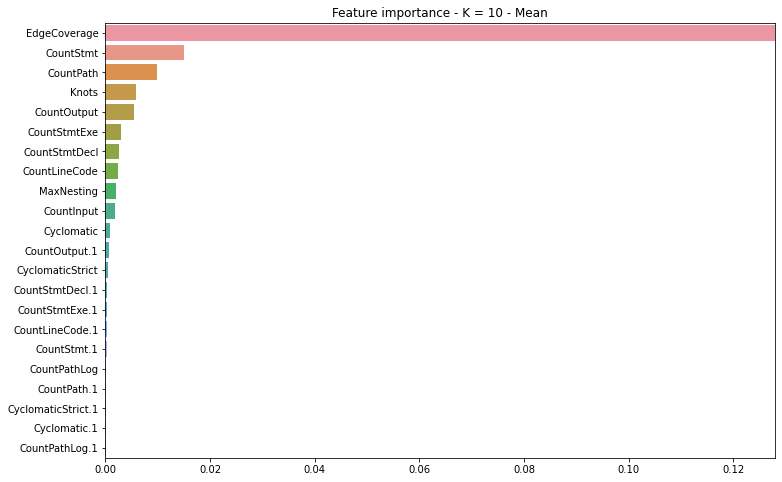

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0786762,0.0786762
Mean Sqr Error,0.0188811,0.0188811
Mean Sqr Log Error,0.00903727,0.00903727
Mean Median Error,0.034867,0.034867
R2 Score,0.826749,0.826749


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0787833,0.0787833
Mean Sqr Error,0.0189386,0.0189386
Mean Sqr Log Error,0.00906076,0.00906076
Mean Median Error,0.0352914,0.0352914
R2 Score,0.82617,0.82617


In [109]:
evaluate_random_forest(previsores, display_feature_importance=True)

## EC

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
0,EdgeCoverage,0.190056


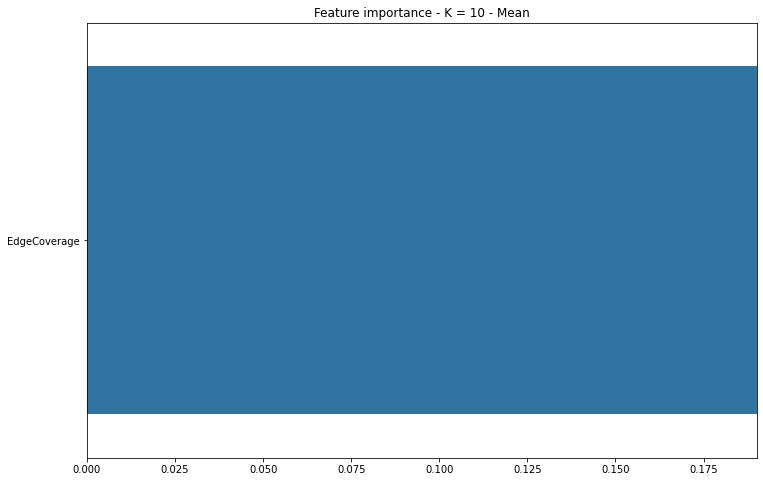

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


In [110]:
evaluate_random_forest([
    'EdgeCoverage'
], display_feature_importance=True)

# Avaliação dos modelos com variação das métricas

In [27]:
melhores_previsores = [
    'CountPath',
    'CountLineCode',
    'MaxNesting',
    'CountStmtExe.1',
    'CountOutput.1',
    'CountInput',
    'CountStmt',
    'CountStmtExe',
    'CountStmtDecl.1',
    'CountOutput',
    'Cyclomatic',
    'CountStmt.1',
    'CountLineCode.1',
    'Knots'
]

melhores_previsores_com_ec = [
    'CountPath',
    'CountLineCode',
    'MaxNesting',
    'CountStmtExe.1',
    'CountOutput.1',
    'CountInput',
    'CountStmt',
    'CountStmtExe',
    'CountStmtDecl.1',
    'CountOutput',
    'Cyclomatic',
    'CountStmt.1',
    'CountLineCode.1',
    'Knots',
    'EdgeCoverage'
]

### Funções auxiliares

In [14]:
from itertools import chain, combinations

def powerset(iterable):
    "list(powerset([1,2,3])) --> [(), (1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)]"
    s = list(iterable)
    it = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

    powerset_list = []

    for element in it:
        subset_list = []
        for subset_element in element:
            subset_list.append(subset_element)

        powerset_list.append(subset_list)
        
    return powerset_list

In [15]:
def evaluate_metrics_brute_force(metrics=previsores, history=10):
    metrics_powerset = powerset(metrics)
    metrics_powerset.remove([]) # Removes empty subset
    
    results = pd.DataFrame(
        index=[i for i in range(history)],
        columns=['R2', 'Metrics'],
        data=[[0.0, '']]
    )

    for subset_metrics_powerset in metrics_powerset:
        error_metrics = evaluate(subset_metrics_powerset, RandomForestRegressor(random_state=0), dataset)
        idx_min_r2 = results['R2'].argmin()

        results.loc[idx_min_r2, 'R2'] = float(error_metrics['no_scaled'][4]) # R2
        results.loc[idx_min_r2, 'Metrics'] = str([str(metric) for metric in subset_metrics_powerset])

    return results

## SCM

In [18]:
results = evaluate_metrics_brute_force(melhores_previsores, history=10)

<AxesSubplot:xlabel='R2', ylabel='Metrics'>

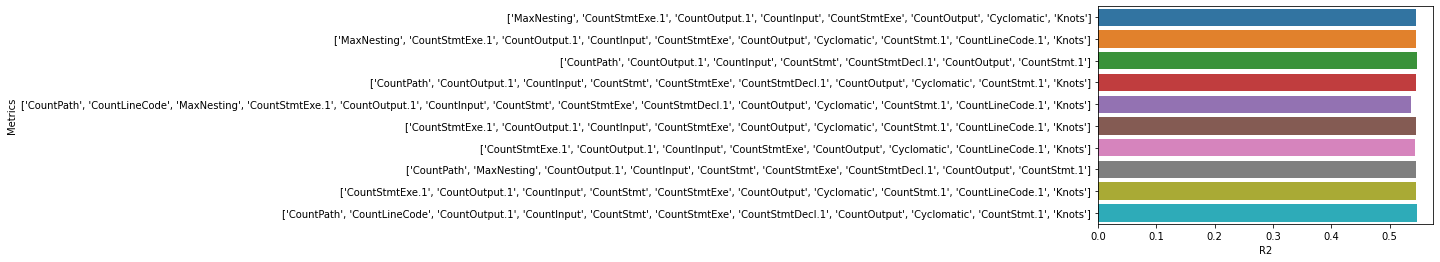

In [19]:
sns.barplot(x='R2', y='Metrics', data=results, orient='h')

In [23]:
pd.set_option('display.max_colwidth', 500)
results.sort_values(by="R2", ascending=False)

,R2,Metrics
2,0.546646,"['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1']"
9,0.546406,"['CountPath', 'CountLineCode', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots']"
1,0.545886,"['MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"
8,0.545516,"['CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"
7,0.544882,"['CountPath', 'MaxNesting', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1']"
3,0.544827,"['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots']"
0,0.544818,"['MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'Knots']"
5,0.544211,"['CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"
6,0.544151,"['CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountLineCode.1', 'Knots']"
4,0.535797,"['CountPath', 'CountLineCode', 'MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"


In [26]:
evaluate_random_forest(['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147094,0.147094
Mean Sqr Error,0.047246,0.047246
Mean Sqr Log Error,0.021487,0.021487
Mean Median Error,0.100898,0.100898
R2 Score,0.546646,0.546646


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147235,0.147235
Mean Sqr Error,0.047452,0.047452
Mean Sqr Log Error,0.021619,0.021619
Mean Median Error,0.100503,0.100503
R2 Score,0.54555,0.54555


## SCM + EC

In [28]:
results_com_ec = evaluate_metrics_brute_force(melhores_previsores_com_ec, history=10)

In [29]:
pd.set_option('display.max_colwidth', 500)
results_com_ec.sort_values(by="R2", ascending=False)

,R2,Metrics
7,0.844454,"['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
0,0.844249,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots', 'EdgeCoverage']"
8,0.843752,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountLineCode.1', 'Knots', 'EdgeCoverage']"
3,0.843669,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
4,0.843291,"['MaxNesting', 'CountStmtExe.1', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
1,0.843205,"['CountLineCode', 'MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
2,0.843134,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Knots', 'EdgeCoverage']"
6,0.842864,"['CountLineCode', 'MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots', 'EdgeCoverage']"
9,0.842853,"['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots', 'EdgeCoverage']"
5,0.827074,"['CountPath', 'CountLineCode', 'MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots', 'EdgeCoverage']"


<AxesSubplot:xlabel='R2', ylabel='Metrics'>

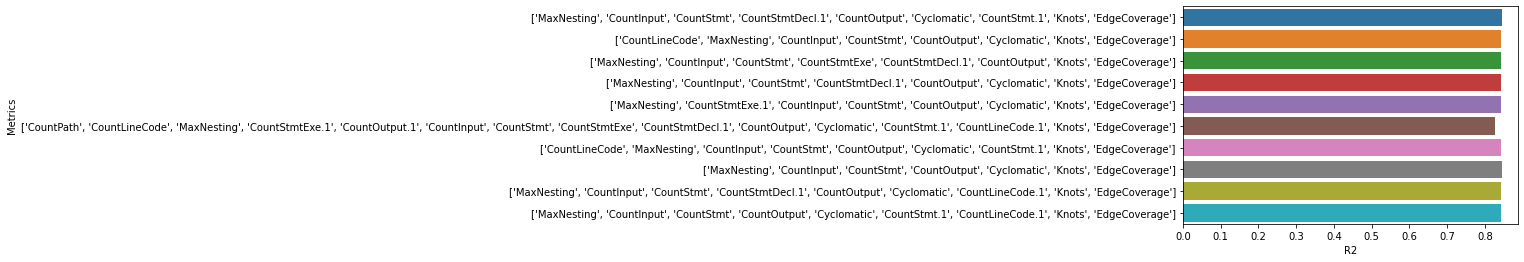

In [30]:
sns.barplot(x='R2', y='Metrics', data=results_com_ec, orient='h')

In [31]:
evaluate_random_forest(['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.074011,0.074011
Mean Sqr Error,0.016937,0.016937
Mean Sqr Log Error,0.008181,0.008181
Mean Median Error,0.03406,0.03406
R2 Score,0.844454,0.844454


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.073978,0.073978
Mean Sqr Error,0.016966,0.016966
Mean Sqr Log Error,0.008191,0.008191
Mean Median Error,0.034304,0.034304
R2 Score,0.844336,0.844336


In [32]:
evaluate_random_forest([
    'MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 
    'Cyclomatic', 'CountStmt.1', 'Knots', 'EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.074802,0.074802
Mean Sqr Error,0.016928,0.016928
Mean Sqr Log Error,0.008173,0.008173
Mean Median Error,0.037938,0.037938
R2 Score,0.844249,0.844249


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.074806,0.074806
Mean Sqr Error,0.016961,0.016961
Mean Sqr Log Error,0.008187,0.008187
Mean Median Error,0.038116,0.038116
R2 Score,0.844017,0.844017


### EC

### Não se aplica

# Validation curves (seleção de parametros para tuning)

In [70]:
from sklearn.model_selection import validation_curve

In [117]:
def plot_validation_curve(train_score, test_score, param_range):
    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    test_scores_mean = np.mean(test_score, axis=1)
    test_scores_std = np.std(test_score, axis=1)

    plt.title("Validation Curve with Random Forest")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

def evaluate_validation_curve(param_name, param_range, labels = melhores_previsores):
    train_scoreNum, test_scoreNum = validation_curve(
            RandomForestRegressor(),
            X = dataset[labels].values, y = dataset['PrimePathCoverage'].values, 
            param_name = param_name, 
            param_range = param_range, cv = 10
    )
    
    plot_validation_curve(train_scoreNum, test_scoreNum, param_range)

## SCM

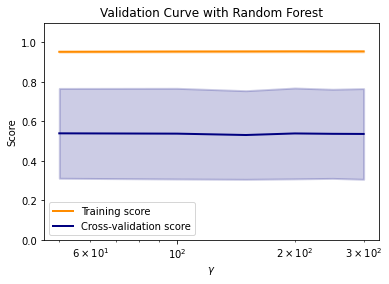

In [92]:
evaluate_validation_curve('n_estimators', [50, 100, 150, 200, 250, 300])

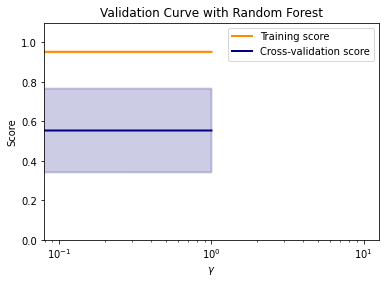

In [93]:
evaluate_validation_curve('criterion', ['mse', 'mae'])

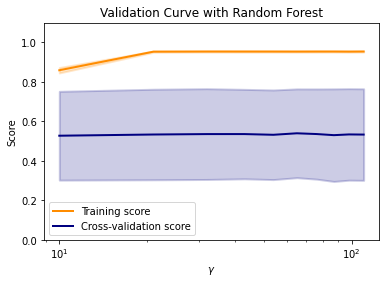

In [94]:
param_range = [x for x in np.linspace(10, 110, num = 10, dtype=int)]
evaluate_validation_curve('max_depth', param_range)

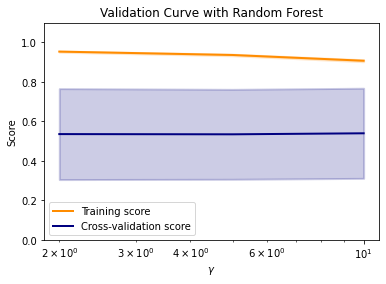

In [95]:
evaluate_validation_curve('min_samples_split', [2, 5, 10])

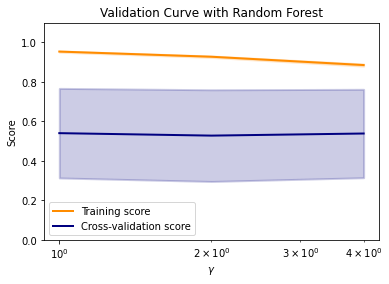

In [96]:
evaluate_validation_curve('min_samples_leaf', [1, 2, 4])

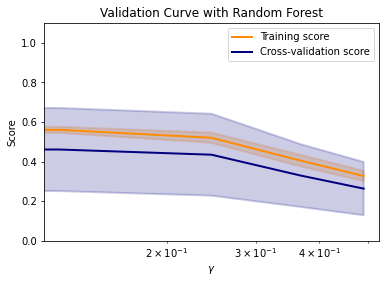

In [146]:
evaluate_validation_curve('min_weight_fraction_leaf', [x for x in np.linspace(0.0, 0.49, 5, dtype=float)])

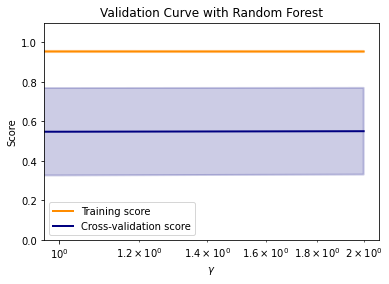

In [98]:
evaluate_validation_curve('max_features', ['auto', 'sqrt', 'log2'])

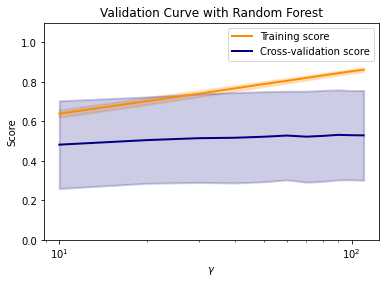

In [99]:
param_range = [x for x in np.linspace(10, 110, num = 11, dtype=int)]
evaluate_validation_curve('max_leaf_nodes', param_range)

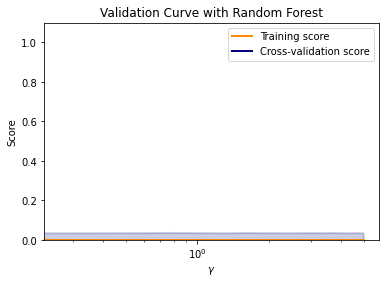

In [100]:
evaluate_validation_curve('min_impurity_decrease', [x for x in np.linspace(0.0, 5.0, 20)])

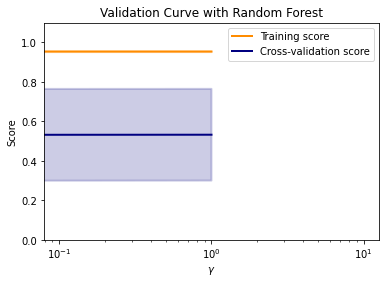

In [101]:
evaluate_validation_curve('bootstrap', [True, False])

## SCM + EC

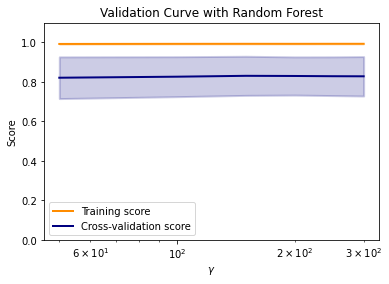

In [118]:
evaluate_validation_curve('n_estimators', [50, 100, 150, 200, 250, 300], melhores_previsores_com_ec)

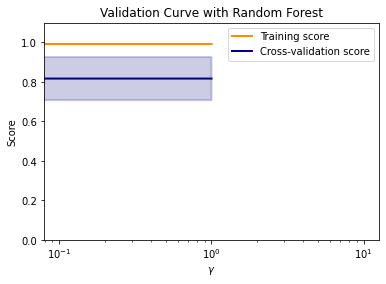

In [119]:
evaluate_validation_curve('criterion', ['mse', 'mae'], melhores_previsores_com_ec)

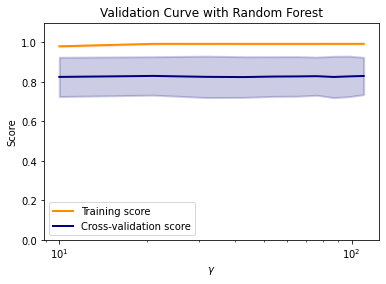

In [120]:
param_range = [x for x in np.linspace(10, 110, num = 10, dtype=int)]
evaluate_validation_curve('max_depth', param_range, melhores_previsores_com_ec)

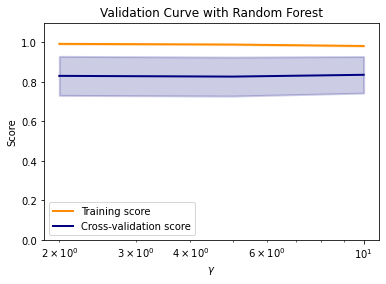

In [121]:
evaluate_validation_curve('min_samples_split', [2, 5, 10], melhores_previsores_com_ec)

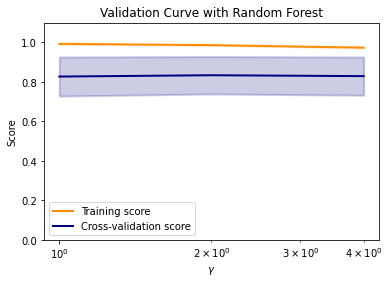

In [122]:
evaluate_validation_curve('min_samples_leaf', [1, 2, 4], melhores_previsores_com_ec)

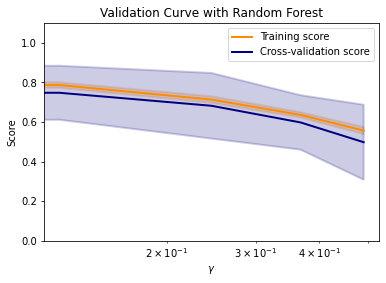

In [145]:
evaluate_validation_curve('min_weight_fraction_leaf', [x for x in np.linspace(0.0, 0.49, 5, dtype=float)], melhores_previsores_com_ec)

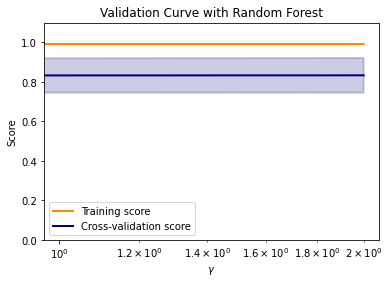

In [124]:
evaluate_validation_curve('max_features', ['auto', 'sqrt', 'log2'], melhores_previsores_com_ec)

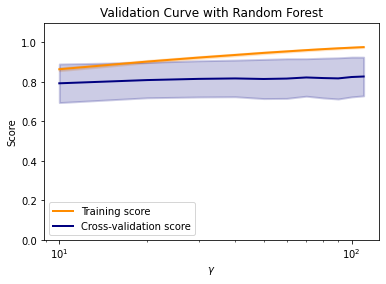

In [125]:
param_range = [x for x in np.linspace(10, 110, num = 11, dtype=int)]
evaluate_validation_curve('max_leaf_nodes', param_range, melhores_previsores_com_ec)

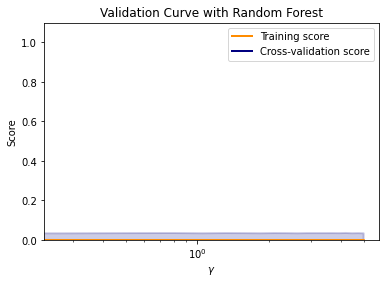

In [126]:
evaluate_validation_curve('min_impurity_decrease', [x for x in np.linspace(0.0, 5.0, 20)], melhores_previsores_com_ec)

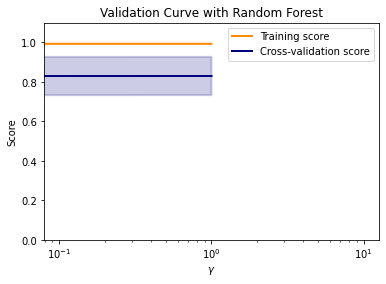

In [127]:
evaluate_validation_curve('bootstrap', [True, False], melhores_previsores_com_ec)

## EC

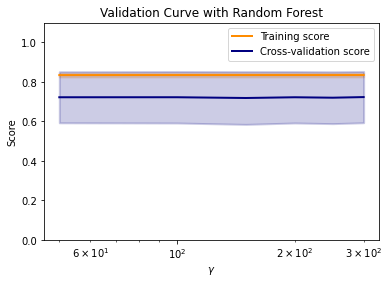

In [128]:
evaluate_validation_curve('n_estimators', [50, 100, 150, 200, 250, 300], ['EdgeCoverage'])

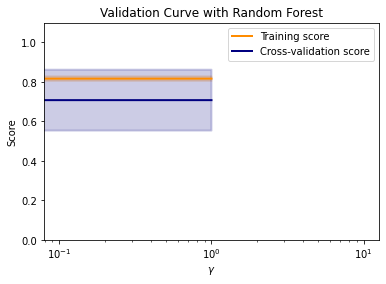

In [129]:
evaluate_validation_curve('criterion', ['mse', 'mae'], ['EdgeCoverage'])

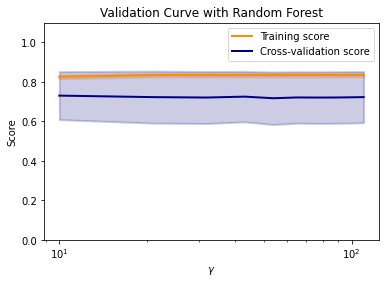

In [130]:
param_range = [x for x in np.linspace(10, 110, num = 10, dtype=int)]
evaluate_validation_curve('max_depth', param_range, ['EdgeCoverage'])

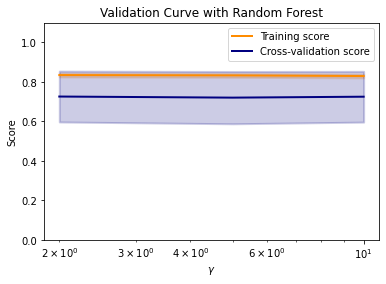

In [131]:
evaluate_validation_curve('min_samples_split', [2, 5, 10], ['EdgeCoverage'])

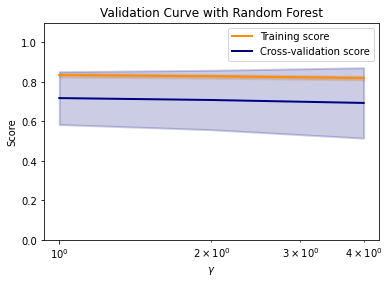

In [132]:
evaluate_validation_curve('min_samples_leaf', [1, 2, 4], ['EdgeCoverage'])

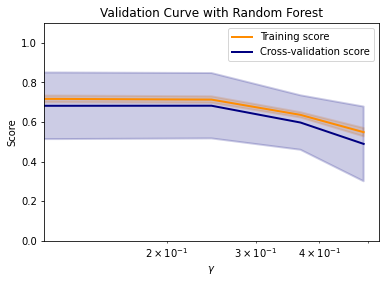

In [144]:
evaluate_validation_curve('min_weight_fraction_leaf', [x for x in np.linspace(0.0, 0.49, 5, dtype=float)], ['EdgeCoverage'])

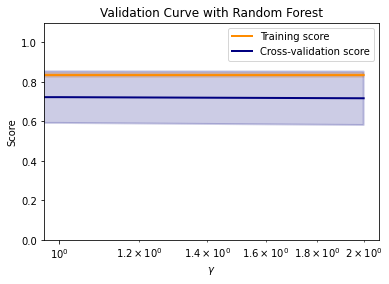

In [134]:
evaluate_validation_curve('max_features', ['auto', 'sqrt', 'log2'], ['EdgeCoverage'])

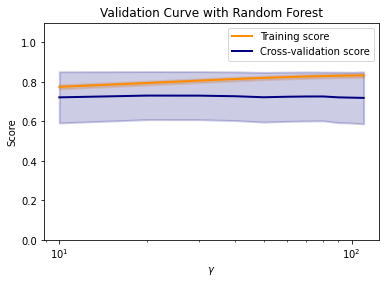

In [135]:
param_range = [x for x in np.linspace(10, 110, num = 11, dtype=int)]
evaluate_validation_curve('max_leaf_nodes', param_range, ['EdgeCoverage'])

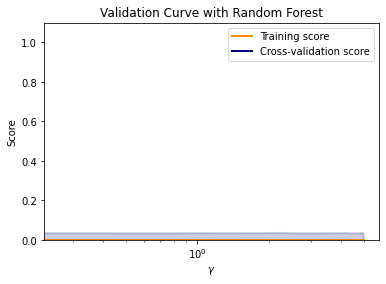

In [136]:
evaluate_validation_curve('min_impurity_decrease', [x for x in np.linspace(0.0, 5.0, 20)], ['EdgeCoverage'])

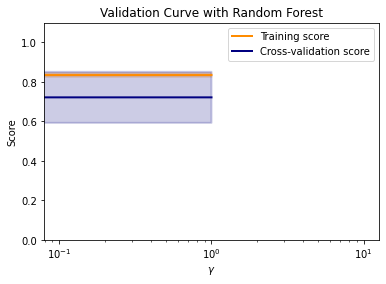

In [137]:
evaluate_validation_curve('bootstrap', [True, False], ['EdgeCoverage'])

# Tuning hyper-parameters

In [154]:
from sklearn.model_selection import RandomizedSearchCV

def evaluate_hyperparam_rf_scm():
    hyperparam_space = {
        'min_weight_fraction_leaf': [x for x in np.linspace(0.0, 0.49, 5, dtype=float)],
        'max_depth':[x for x in np.linspace(10, 110, num = 10, dtype=int)],
        'min_samples_split':[2, 5, 10],
        'min_samples_leaf':[1, 2, 4],
        'max_leaf_nodes':[x for x in np.linspace(10, 110, num = 11, dtype=int)]
    }
    
    random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(), 
            param_distributions=hyperparam_space,
            n_iter=100,
            cv=10,
            random_state=0
    )

    random_search.fit(dataset[melhores_previsores].values, dataset['PrimePathCoverage'].values)
    
    display(random_search.best_params_)
    
    return random_search

def evaluate_hyperparam_rf_scm_ec():
    hyperparam_space = {
        'max_depth':[x for x in np.linspace(10, 110, num = 10, dtype=int)],
        'min_weight_fraction_leaf': [x for x in np.linspace(0.0, 0.49, 5, dtype=float)],
        'max_leaf_nodes':[x for x in np.linspace(10, 110, num = 11, dtype=int)]
    }
    
    random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(), 
            param_distributions=hyperparam_space,
            n_iter=100,
            cv=10,
            random_state=0
    )

    
    random_search.fit(dataset[melhores_previsores_com_ec].values, dataset['PrimePathCoverage'].values)
    
    display(random_search.best_params_)
    
    return random_search

def evaluate_hyperparam_rf_ec():
    hyperparam_space = {
        'min_weight_fraction_leaf': [x for x in np.linspace(0.0, 0.49, 5, dtype=float)],
        'max_leaf_nodes':[x for x in np.linspace(10, 110, num = 11, dtype=int)]
    }
    
    random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(), 
            param_distributions=hyperparam_space,
            n_iter=100,
            cv=10,
            random_state=0
    )

    random_search.fit(dataset['EdgeCoverage'].values.reshape(-1,1), dataset['PrimePathCoverage'].values)
    
    display(random_search.best_params_)
    
    return random_search

### SCM

In [149]:
results_scm = evaluate_hyperparam_rf_scm()

{'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 90,
 'max_depth': 110}

### SCM + EC

In [150]:
results_scm_ec = evaluate_hyperparam_rf_scm_ec()

{'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': 60, 'max_depth': 87}

### EC

In [155]:
results_ec = evaluate_hyperparam_rf_ec()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 55 is smaller than n_iter=100. Running 55 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': 30}

# Executando algoritmos com tuning

In [159]:
def evaluate_random_forest_tuning_scm(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i, min_weight_fraction_leaf=0.0, min_samples_split=5, min_samples_leaf=1, max_leaf_nodes=90, max_depth=110), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)
    
def evaluate_random_forest_tuning_scm_ec(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i, min_weight_fraction_leaf=0.0, max_leaf_nodes=90, max_depth=87), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)
    
def evaluate_random_forest_tuning_ec(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i, min_weight_fraction_leaf=0.0, max_leaf_nodes=30), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

## SCM

In [160]:
evaluate_random_forest_tuning_scm(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.152231,0.152231
Mean Sqr Error,0.048535,0.048535
Mean Sqr Log Error,0.022192,0.022192
Mean Median Error,0.116175,0.116175
R2 Score,0.537998,0.537998


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.152268,0.152268
Mean Sqr Error,0.048708,0.048708
Mean Sqr Log Error,0.02229,0.02229
Mean Median Error,0.115903,0.115903
R2 Score,0.536406,0.536406


## SCM + EC

In [161]:
evaluate_random_forest_tuning_scm_ec(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.081767,0.081767
Mean Sqr Error,0.019448,0.019448
Mean Sqr Log Error,0.009373,0.009373
Mean Median Error,0.038175,0.038175
R2 Score,0.820893,0.820893


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.081796,0.081796
Mean Sqr Error,0.019436,0.019436
Mean Sqr Log Error,0.009366,0.009366
Mean Median Error,0.037944,0.037944
R2 Score,0.820903,0.820903


## EC

In [162]:
evaluate_random_forest_tuning_ec(['EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.124163,0.124163
Mean Sqr Error,0.029534,0.029534
Mean Sqr Log Error,0.014016,0.014016
Mean Median Error,0.078397,0.078397
R2 Score,0.730579,0.730579


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.124163,0.124163
Mean Sqr Error,0.029534,0.029534
Mean Sqr Log Error,0.014016,0.014016
Mean Median Error,0.078397,0.078397
R2 Score,0.730579,0.730579


# Validação

In [9]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def get_cross_validate_estimators_scaled(previsores):
    d = dataset
    k = 10
    classificador = RandomForestRegressor(random_state=0)
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )

    return resultados_escalonados['estimator']

def get_cross_validate_estimators_noscaled(previsores):
    d = dataset
    k = 10
    classificador = RandomForestRegressor(random_state=0)
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    return resultados['estimator']

In [ ]:
def avaliar_rf_validacao_externa(estimadores_dataset_treinado, dataset_externo, display_prediction = False):
    for estimator in resultados_escalonados['estimator']:
        ppc_predict = estimator.predict(escalonador(previsores_content))
        results = pd.DataFrame(index=[i for i in range(len(ppc_predict))],columns=['PPC correct', 'PPC predict', 'MAE'])

        for i in range(len(ppc_predict)):
            predict_table['PPC correct'][i] = ppc[i]
            predict_table['PPC predict'][i] = ppc_predict[i]
            predict_table['MAE'][i] = abs(ppc[i] - ppc_predict[i])
            #print(ppc_predict[i], ppc[i])

## Commons IO

In [322]:
load_dataset('commons-io-commons-io-2.6.csv')
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
under_sampling({1:13, 2:54})
select_metrics(selected_metrics)

Dataset size:  112
Média complexidade dataset balanceado:  3.017857142857143


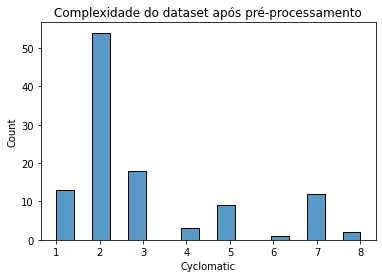

In [323]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

Dataset size:  213
Média complexidade dataset:  2.427230046948357


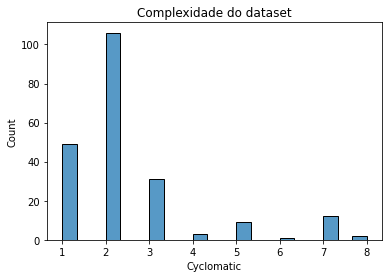

In [324]:
print('Dataset size: ', dataset_original.shape[0])
print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
plt.title("Complexidade do dataset")
sns.histplot(dataset_original['Cyclomatic'])
plt.show()

### SCM

#### Usando melhores metricas

In [325]:
evaluate_random_forest(['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.187006,0.187006
Mean Sqr Error,0.056839,0.056839
Mean Sqr Log Error,0.024591,0.024591
Mean Median Error,0.158372,0.158372
R2 Score,0.105726,0.105726


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.186168,0.186168
Mean Sqr Error,0.056024,0.056024
Mean Sqr Log Error,0.024258,0.024258
Mean Median Error,0.157292,0.157292
R2 Score,0.118262,0.118262


#### Usando todas metricas

In [326]:
evaluate_random_forest(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.192638,0.192638
Mean Sqr Error,0.059947,0.059947
Mean Sqr Log Error,0.02576,0.02576
Mean Median Error,0.166482,0.166482
R2 Score,0.059244,0.059244


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.193221,0.193221
Mean Sqr Error,0.06009,0.06009
Mean Sqr Log Error,0.025809,0.025809
Mean Median Error,0.166579,0.166579
R2 Score,0.063917,0.063917


### SCM + EC

#### Usando melhores metricas

In [327]:
evaluate_random_forest(['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.068001,0.068001
Mean Sqr Error,0.019097,0.019097
Mean Sqr Log Error,0.009311,0.009311
Mean Median Error,0.016458,0.016458
R2 Score,0.702253,0.702253


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.068279,0.068279
Mean Sqr Error,0.01913,0.01913
Mean Sqr Log Error,0.009361,0.009361
Mean Median Error,0.017257,0.017257
R2 Score,0.697598,0.697598


#### Usando todas metricas

In [328]:
evaluate_random_forest(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.060248,0.060248
Mean Sqr Error,0.015999,0.015999
Mean Sqr Log Error,0.007786,0.007786
Mean Median Error,0.019694,0.019694
R2 Score,0.741473,0.741473


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.06033,0.06033
Mean Sqr Error,0.015973,0.015973
Mean Sqr Log Error,0.007799,0.007799
Mean Median Error,0.019875,0.019875
R2 Score,0.742698,0.742698


### EC

#### Usando melhores metricas

In [329]:
evaluate_random_forest(['EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.087777,0.087777
Mean Sqr Error,0.024687,0.024687
Mean Sqr Log Error,0.011104,0.011104
Mean Median Error,0.042567,0.042567
R2 Score,0.609081,0.609081


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.087777,0.087777
Mean Sqr Error,0.024687,0.024687
Mean Sqr Log Error,0.011104,0.011104
Mean Median Error,0.042567,0.042567
R2 Score,0.609081,0.609081


#### Usando todas metricas